# Movie Hit Prediction at NeoStudio Pictures
## Part 2: Machine Learning Models

---

### Executive Summary

**Business Context**: We are data scientists at **NeoStudio Pictures**, a mid-size production company navigating an increasingly competitive film industry. Every year, executives face the critical decision: which movie projects should we greenlight? With production budgets ranging from tens to hundreds of millions of dollars, making the wrong call can be catastrophic.

**The Challenge**: Before a single frame is shot, can we predict whether a movie will become a box office hit (≥$100M worldwide revenue)?

**Our Solution**: This notebook presents the **machine learning modeling** phase of our comprehensive system, building on the feature-engineered dataset created in `EDA.ipynb`.

---

### Prerequisites

This notebook requires the processed dataset from `EDA.ipynb`:
- **Input file**: `data/processed/movies_model_ready.csv`

---

### What This Notebook Covers

| Section | Description | Key Deliverables |
|---------|-------------|------------------|
| **Part 6: Baseline Models** | Simple models to establish performance floor | Logistic regression benchmark |
| **Part 7: Advanced Models** | Random Forest, XGBoost, LightGBM | Production-ready classifier |
| **Part 8: Revenue Prediction** | Regression models for box office forecasting | Revenue prediction system |
| **Part 9: Business Applications** | Threshold tuning, recommendations | Actionable executive dashboard |

---

### Dataset: TMDB 5000 Movies (Processed)

- **Source**: Feature-engineered dataset from `EDA.ipynb`
- **File**: `data/processed/movies_model_ready.csv`
- **Size**: ~3,229 movies × 45 features

---

---

# Environment Setup

First, we'll install and import all necessary libraries for machine learning modeling.

In [ ]:
# Install required packages (automatically handled in Colab)
!pip install -q pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm

In [ ]:
# Import core libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, classification_report,
                             mean_squared_error, mean_absolute_error, r2_score)
import xgboost as xgb
import lightgbm as lgb

# Configure visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print(" All packages imported successfully!")
print(f" Pandas version: {pd.__version__}")
print(f" NumPy version: {np.__version__}")
print(f" Scikit-learn is ready")
print(f" XGBoost and LightGBM are ready")

---

# Part 6: Machine Learning Models

## 6.1 Splitting Data for Training and Testing (Temporal Split)

**Key Idea:** We want to train our model on past movies and test it on newer ones, just like predicting the future in real life.

- **Training Set:** Movies released **before 2010**  
- **Validation Set:** Movies released **2010–2012**  
- **Test Set:** Movies released **2013 and later**

**Why this split?**  
Randomly mixing old and new movies could give the model a peek into the future, which is unrealistic. Using a temporal split avoids this “cheating” and gives a better estimate of how the model will perform in the real world.

---

In [ ]:
# Reload the processed dataset (in case you're running this section separately)
df = pd.read_csv('data/processed/movies_model_ready.csv')

print("TEMPORAL TRAIN/VALIDATION/TEST SPLIT")
print("\nSimulating real-world scenario: train on past, predict the future\n")

# Sort by release year
df = df.sort_values('release_year').reset_index(drop=True)

# Create temporal splits
train_df = df[df['release_year'] < 2010].copy()
val_df = df[(df['release_year'] >= 2010) & (df['release_year'] <= 2012)].copy()
test_df = df[df['release_year'] >= 2013].copy()

print(" TRAIN SET (Before 2010):")
print(f"   - Size: {len(train_df):,} movies")
print(f"   - Years: {int(train_df['release_year'].min())} - {int(train_df['release_year'].max())}")
print(f"   - Hit rate: {train_df['hit'].mean()*100:.1f}%")

print("\n VALIDATION SET (2010-2012):")
print(f"   - Size: {len(val_df):,} movies")
print(f"   - Years: {int(val_df['release_year'].min())} - {int(val_df['release_year'].max())}")
print(f"   - Hit rate: {val_df['hit'].mean()*100:.1f}%")

print("\n TEST SET (2013+):")
print(f"   - Size: {len(test_df):,} movies")
print(f"   - Years: {int(test_df['release_year'].min())} - {int(test_df['release_year'].max())}")
print(f"   - Hit rate: {test_df['hit'].mean()*100:.1f}%")

# Define feature columns (exclude targets and identifiers)
exclude_cols = ['hit', 'log_revenue', 'worldwide_revenue', 'title',
               'release_date', 'director', 'primary_genre', 'budget_bucket',
               'genre_list'] # Added 'genre_list' here

feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"\n🔧 Number of features for modeling: {len(feature_cols)}")
print(f"   Features: {', '.join(feature_cols[:10])}...")

# Separate features and targets
X_train = train_df[feature_cols].copy()
y_train = train_df['hit'].copy()
y_train_revenue = train_df['log_revenue'].copy()

X_val = val_df[feature_cols].copy()
y_val = val_df['hit'].copy()
y_val_revenue = val_df['log_revenue'].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df['hit'].copy()
y_test_revenue = test_df['log_revenue'].copy()

# Handle any remaining missing values
X_train = X_train.fillna(X_train.median(numeric_only=True))
X_val = X_val.fillna(X_train.median(numeric_only=True))  # Use train median to avoid leakage
X_test = X_test.fillna(X_train.median(numeric_only=True))

# Standardize numerical features (important for some models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\n Data split and preprocessing complete!")
print(" Features standardized (zero mean, unit variance)")

TEMPORAL TRAIN/VALIDATION/TEST SPLIT

Simulating real-world scenario: train on past, predict the future

 TRAIN SET (Before 2010):
   - Size: 2,282 movies
   - Years: 1916 - 2009
   - Hit rate: 32.2%

 VALIDATION SET (2010-2012):
   - Size: 467 movies
   - Years: 2010 - 2012
   - Hit rate: 37.3%

 TEST SET (2013+):
   - Size: 480 movies
   - Years: 2013 - 2016
   - Hit rate: 45.0%

🔧 Number of features for modeling: 37
   Features: release_year, budget, log_budget, budget_millions, runtime, num_genres, has_big_studio, num_production_companies, release_month, release_quarter...

 Data split and preprocessing complete!
 Features standardized (zero mean, unit variance)


---

## 6.2 Baseline Models

**Why start simple?**  
Before building complex machine learning models, we first check how simple approaches perform. This sets a **baseline**—the minimum performance any advanced model should beat.

---

### Baseline 1: Naive Predictor

**Idea:** Always predict the most common outcome (majority class).  
- Gives us the absolute minimum performance.  
- Think of it as saying: *“All movies will be hits”* if hits are more common.

---

### Baseline 2: Logistic Regression

**Idea:** A simple linear model that predicts the probability of a movie being a hit.  
- Easy to interpret: we can see which features push a movie towards being a hit or a flop.  
- Surprisingly effective in many real-world scenarios.

---

### Understanding Feature Importance

We can see **which features influence a hit** the most:  

- **Positive Influencers:** Features that increase the chance of a movie being a hit.  
- **Negative Influencers:** Features that make a movie less likely to succeed.

---

**Summary:**  
- The **naive predictor** gives a floor for performance.  
- **Logistic Regression** usually performs better and helps us understand what drives hits.  
- Always compare new models against this baseline to see real improvements.


In [ ]:
print("="*80)
print("BASELINE MODEL 1: NAIVE PREDICTOR")
print("="*80)

# Always predict majority class
majority_class = y_train.mode()[0]
y_pred_naive = np.full(len(y_test), majority_class)

naive_accuracy = accuracy_score(y_test, y_pred_naive)

print(f"\nStrategy: Always predict class {majority_class} ({'Hit' if majority_class == 1 else 'Non-Hit'})")
print(f"\n Performance:")
print(f"   Accuracy: {naive_accuracy:.4f} ({naive_accuracy*100:.2f}%)")
print(f"\n This is our floor - any real model must beat {naive_accuracy*100:.1f}% accuracy!")

BASELINE MODEL 1: NAIVE PREDICTOR

Strategy: Always predict class 0 (Non-Hit)

 Performance:
   Accuracy: 0.5500 (55.00%)

 This is our floor - any real model must beat 55.0% accuracy!


In [ ]:
print("BASELINE MODEL 2: LOGISTIC REGRESSION")

# Train logistic regression with L2 regularization
log_reg = LogisticRegression(max_iter=1000, random_state=42, C=1.0)
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = log_reg.predict(X_test_scaled)
y_pred_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("\n Logistic Regression Performance:")
print(f"   Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"   Precision (Hit): {precision_score(y_test, y_pred_lr):.4f}")
print(f"   Recall (Hit): {recall_score(y_test, y_pred_lr):.4f}")
print(f"   F1 Score (Hit): {f1_score(y_test, y_pred_lr):.4f}")
print(f"   ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Non-Hit', 'Hit']))

# Feature importance (coefficients)
feature_importance_lr = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': log_reg.coef_[0]
}).sort_values('coefficient', ascending=False)

print("\n🔍 Top 10 Most Important Features (Positive Influence):")
display(feature_importance_lr.head(10))

print("\n🔍 Top 10 Least Important Features (Negative Influence):")
display(feature_importance_lr.tail(10))

BASELINE MODEL 2: LOGISTIC REGRESSION

 Logistic Regression Performance:
   Accuracy: 0.8958
   Precision (Hit): 0.8517
   Recall (Hit): 0.9306
   F1 Score (Hit): 0.8894
   ROC-AUC: 0.9712

 Classification Report:
              precision    recall  f1-score   support

     Non-Hit       0.94      0.87      0.90       264
         Hit       0.85      0.93      0.89       216

    accuracy                           0.90       480
   macro avg       0.90      0.90      0.90       480
weighted avg       0.90      0.90      0.90       480


🔍 Top 10 Most Important Features (Positive Influence):


,feature,coefficient
21,log_vote_count,2.499719
17,director_hit_rate,2.341898
2,log_budget,0.783482
11,is_holiday,0.383220
19,log_popularity,0.330439
8,release_month,0.315989
5,num_genres,0.241763
10,is_summer,0.205015
1,budget,0.198582
3,budget_millions,0.198582



🔍 Top 10 Least Important Features (Negative Influence):


,feature,coefficient
34,genre_Animation,-0.168573
36,genre_War,-0.182065
24,genre_Thriller,-0.189935
13,years_since_2000,-0.204552
0,release_year,-0.204552
31,genre_Fantasy,-0.313266
9,release_quarter,-0.402833
29,genre_Science Fiction,-0.541820
20,vote_average,-0.782986
16,director_mean_log_revenue,-0.902827


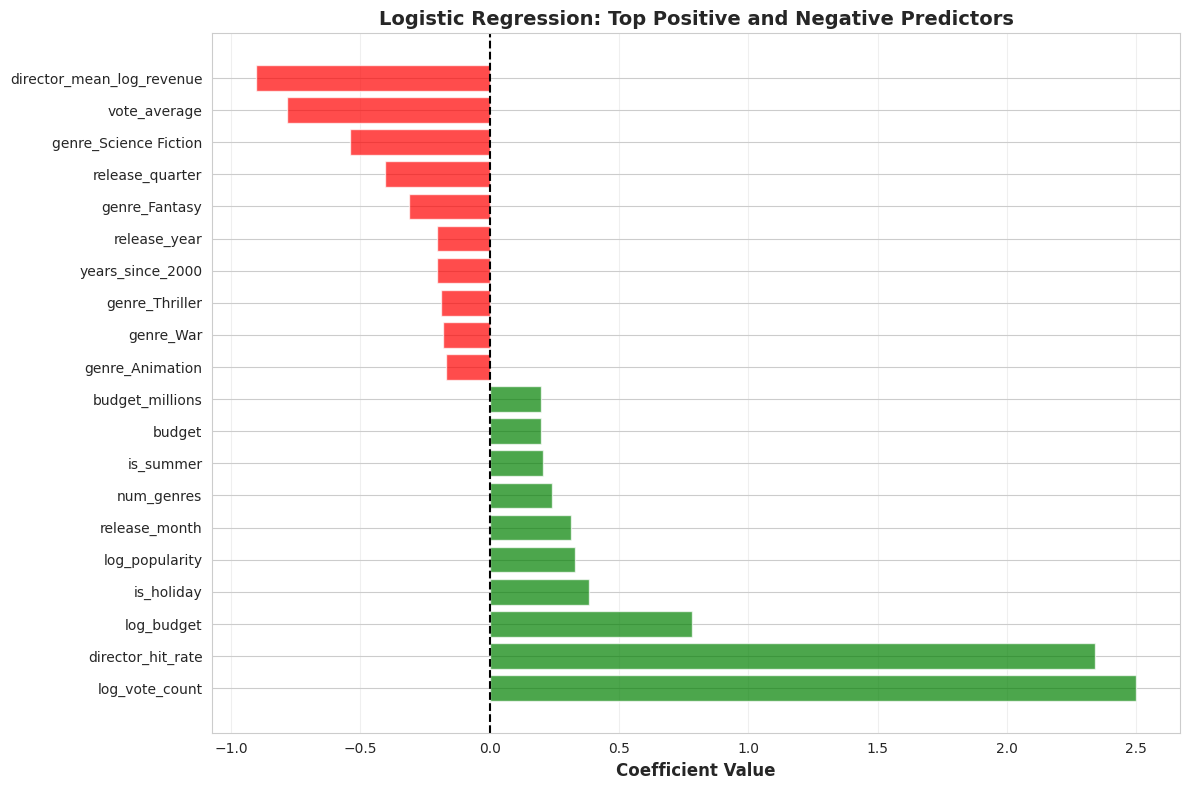


 Baseline models complete!

 Logistic Regression beats naive baseline: 0.896 vs 0.550


In [ ]:
# Visualize logistic regression coefficients
top_features = pd.concat([feature_importance_lr.head(10),
                         feature_importance_lr.tail(10)])

plt.figure(figsize=(12, 8))
colors = ['green' if x > 0 else 'red' for x in top_features['coefficient']]
plt.barh(range(len(top_features)), top_features['coefficient'].values, color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Coefficient Value', fontsize=12, fontweight='bold')
plt.title('Logistic Regression: Top Positive and Negative Predictors', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1.5)
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n Baseline models complete!")
print(f"\n Logistic Regression beats naive baseline: {accuracy_score(y_test, y_pred_lr):.3f} vs {naive_accuracy:.3f}")

---

# Part 7: Advanced Machine Learning Models

## 7.1 Tree-Based Models

Now we move to **advanced models** that can capture complex patterns in data. These models are particularly good at understanding non-linear relationships and interactions between features.

### Models We'll Build:

1. **Random Forest**: A collection of decision trees that work together (bagging) to make predictions more robust.  
2. **XGBoost**: Uses gradient boosting to sequentially improve predictions with advanced regularization.  
3. **LightGBM**: A fast, efficient gradient boosting framework by Microsoft.

**Why choose these models?**  
- Can automatically handle complex, non-linear relationships  
- Robust against outliers and missing data  
- Provide clear insights into which features matter most  
- Often achieve state-of-the-art results on structured/tabular data

---

### Understanding Feature Importance

All three models can tell us which features influence predictions the most:  

- **Positive Impact:** Features that increase the chance of a movie being a hit.  
- **Negative Impact:** Features that decrease the chance of a movie being a hit.

---

**Summary:**  
- These tree-based models are more powerful than simple baselines.  
- They can capture subtle patterns and interactions that simpler models might miss.  
- Feature importance from these models helps us understand what drives success in movies.


ADVANCED MODEL 1: RANDOM FOREST CLASSIFIER

Training Random Forest


 Random Forest Performance:
   Accuracy: 0.8833
   Precision (Hit): 0.8175
   Recall (Hit): 0.9537
   F1 Score (Hit): 0.8803
   ROC-AUC: 0.9650

🔍 Top 15 Most Important Features (Random Forest):


,feature,importance
17,director_hit_rate,0.260234
21,log_vote_count,0.172544
16,director_mean_log_revenue,0.136798
19,log_popularity,0.106001
3,budget_millions,0.059184
2,log_budget,0.055751
1,budget,0.051081
18,director_num_movies,0.025256
14,num_cast,0.017226
4,runtime,0.015590


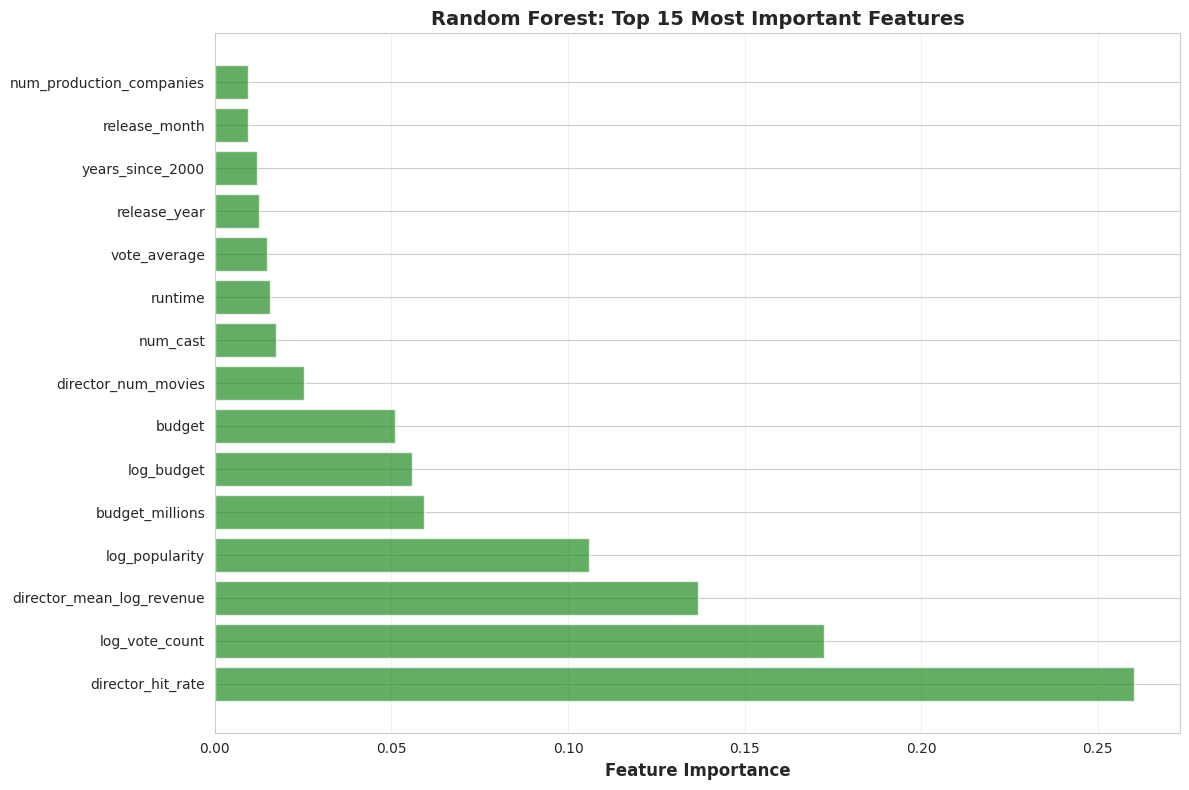

In [ ]:
print("ADVANCED MODEL 1: RANDOM FOREST CLASSIFIER")
print("\nTraining Random Forest\n")

# Train Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf_clf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_clf.predict(X_test)
y_pred_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

# Evaluate
print("\n Random Forest Performance:")
print(f"   Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"   Precision (Hit): {precision_score(y_test, y_pred_rf):.4f}")
print(f"   Recall (Hit): {recall_score(y_test, y_pred_rf):.4f}")
print(f"   F1 Score (Hit): {f1_score(y_test, y_pred_rf):.4f}")
print(f"   ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

# Feature importance
feature_importance_rf = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔍 Top 15 Most Important Features (Random Forest):")
display(feature_importance_rf.head(15))

# Visualize feature importance
plt.figure(figsize=(12, 8))
plt.barh(range(15), feature_importance_rf['importance'].head(15).values, color='forestgreen', alpha=0.7)
plt.yticks(range(15), feature_importance_rf['feature'].head(15).values)
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.title('Random Forest: Top 15 Most Important Features', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [ ]:
print("ADVANCED MODEL 2: XGBoost CLASSIFIER")
print("\nTraining XGBoost\n")

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Train XGBoost
xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

xgb_clf.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_clf.predict(X_test)
y_pred_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]

# Evaluate
print("\n XGBoost Performance:")
print(f"   Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"   Precision (Hit): {precision_score(y_test, y_pred_xgb):.4f}")
print(f"   Recall (Hit): {recall_score(y_test, y_pred_xgb):.4f}")
print(f"   F1 Score (Hit): {f1_score(y_test, y_pred_xgb):.4f}")
print(f"   ROC-AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Non-Hit', 'Hit']))

# Feature importance
feature_importance_xgb = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n Top 15 Most Important Features (XGBoost):")
display(feature_importance_xgb.head(15))

print("\n XGBoost model complete!")

ADVANCED MODEL 2: XGBoost CLASSIFIER

Training XGBoost


 XGBoost Performance:
   Accuracy: 0.9042
   Precision (Hit): 0.8484
   Recall (Hit): 0.9583
   F1 Score (Hit): 0.9000
   ROC-AUC: 0.9755

 Classification Report:
              precision    recall  f1-score   support

     Non-Hit       0.96      0.86      0.91       264
         Hit       0.85      0.96      0.90       216

    accuracy                           0.90       480
   macro avg       0.91      0.91      0.90       480
weighted avg       0.91      0.90      0.90       480


 Top 15 Most Important Features (XGBoost):


,feature,importance
17,director_hit_rate,0.227868
21,log_vote_count,0.069868
16,director_mean_log_revenue,0.048882
19,log_popularity,0.037262
2,log_budget,0.034237
1,budget,0.033794
3,budget_millions,0.032100
35,genre_History,0.030580
11,is_holiday,0.029083
30,genre_Family,0.022146



 XGBoost model complete!


In [ ]:
print("ADVANCED MODEL 3: LightGBM CLASSIFIER")
print("\nTraining LightGBM\n")

# Train LightGBM
lgb_clf = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=42,
    force_col_wise=True,
    verbose=-1
)

lgb_clf.fit(X_train, y_train)

# Predictions
y_pred_lgb = lgb_clf.predict(X_test)
y_pred_proba_lgb = lgb_clf.predict_proba(X_test)[:, 1]

# Evaluate
print("\n LightGBM Performance:")
print(f"   Accuracy: {accuracy_score(y_test, y_pred_lgb):.4f}")
print(f"   Precision (Hit): {precision_score(y_test, y_pred_lgb):.4f}")
print(f"   Recall (Hit): {recall_score(y_test, y_pred_lgb):.4f}")
print(f"   F1 Score (Hit): {f1_score(y_test, y_pred_lgb):.4f}")
print(f"   ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lgb):.4f}")

# Feature importance
feature_importance_lgb = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n Top 15 Most Important Features (LightGBM):")
display(feature_importance_lgb.head(15))


ADVANCED MODEL 3: LightGBM CLASSIFIER

Training LightGBM


 LightGBM Performance:
   Accuracy: 0.9021
   Precision (Hit): 0.8449
   Recall (Hit): 0.9583
   F1 Score (Hit): 0.8980
   ROC-AUC: 0.9762

 Top 15 Most Important Features (LightGBM):


,feature,importance
21,log_vote_count,1129
1,budget,907
17,director_hit_rate,779
16,director_mean_log_revenue,735
19,log_popularity,679
4,runtime,623
14,num_cast,605
20,vote_average,532
0,release_year,461
18,director_num_movies,368


---

## 7.2 Model Comparison & Selection

Once all models are trained, we compare them side-by-side to pick the best one for production.

### Why Compare Models?

- Different models have different strengths.
- We want the model that balances **accuracy, precision, recall, F1 score, and ROC-AUC**.
- Visual comparisons help us quickly see which model performs best across all metrics.

---

### Key Metrics to Consider

- **Accuracy:** Overall correctness of the model.  
- **Precision:** Of the movies predicted as hits, how many were actually hits.  
- **Recall:** Of all actual hits, how many did the model correctly identify.  
- **F1 Score:** Balance between precision and recall.  
- **ROC-AUC:** How well the model distinguishes hits from non-hits (higher is better).

---

### Visual Comparison

1. **Bar charts** show how each model performs on different metrics.  
2. **ROC curves** illustrate how well each model separates hits from non-hits.  
3. **Confusion matrices** provide a detailed breakdown of correct and incorrect predictions.

---

### Choosing the Best Model

- Look for the model with the **highest ROC-AUC** and a good balance of precision and recall.  
- This ensures the model is reliable for production use and minimizes costly mistakes.

---

**Summary:**  
- Comparing models systematically helps pick the most robust one.  
- Tree-based models (Random Forest, XGBoost, LightGBM) often outperform simpler baselines.  
- The selected model becomes the **production champion**, guiding future predictions accurately.


MODEL COMPARISON DASHBOARD

 Performance Metrics Across All Models:



,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Naive Baseline,0.550000,0.000000,0.000000,0.000000,0.500000
1,Logistic Regression,0.895833,0.851695,0.930556,0.889381,0.971240
2,Random Forest,0.883333,0.817460,0.953704,0.880342,0.965015
3,XGBoost,0.904167,0.848361,0.958333,0.900000,0.975466
4,LightGBM,0.902083,0.844898,0.958333,0.898048,0.976168


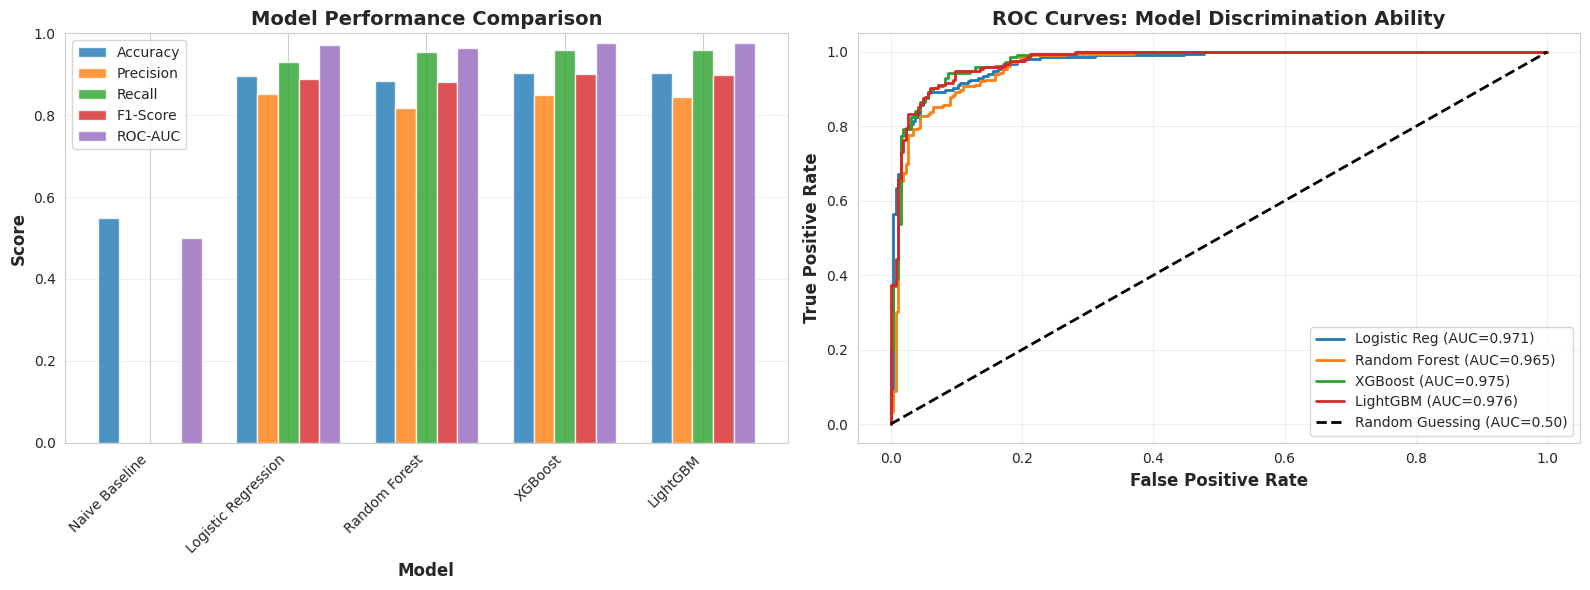


 RECOMMENDED MODEL: LightGBM
   ROC-AUC: 0.9762

 This model provides the best balance of precision and recall for production use.


In [ ]:
print("MODEL COMPARISON DASHBOARD")

# Create comparison table
comparison_data = {
    'Model': ['Naive Baseline', 'Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM'],
    'Accuracy': [
        naive_accuracy,
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_lgb)
    ],
    'Precision': [
        precision_score(y_test, y_pred_naive, zero_division=0),
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb),
        precision_score(y_test, y_pred_lgb)
    ],
    'Recall': [
        recall_score(y_test, y_pred_naive, zero_division=0),
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb),
        recall_score(y_test, y_pred_lgb)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_naive, zero_division=0),
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb),
        f1_score(y_test, y_pred_lgb)
    ],
    'ROC-AUC': [
        0.5,  # Random guessing
        roc_auc_score(y_test, y_pred_proba_lr),
        roc_auc_score(y_test, y_pred_proba_rf),
        roc_auc_score(y_test, y_pred_proba_xgb),
        roc_auc_score(y_test, y_pred_proba_lgb)
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n Performance Metrics Across All Models:\n")
display(comparison_df.style.highlight_max(subset=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
                                         color='lightgreen', axis=0))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparison
x = np.arange(len(comparison_df))
width = 0.15

axes[0].bar(x - 2*width, comparison_df['Accuracy'], width, label='Accuracy', alpha=0.8)
axes[0].bar(x - width, comparison_df['Precision'], width, label='Precision', alpha=0.8)
axes[0].bar(x, comparison_df['Recall'], width, label='Recall', alpha=0.8)
axes[0].bar(x + width, comparison_df['F1-Score'], width, label='F1-Score', alpha=0.8)
axes[0].bar(x + 2*width, comparison_df['ROC-AUC'], width, label='ROC-AUC', alpha=0.8)

axes[0].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')
axes[0].set_ylim([0, 1])

# ROC Curves
from sklearn.metrics import roc_curve

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_proba_lgb)

axes[1].plot(fpr_lr, tpr_lr, linewidth=2, label=f'Logistic Reg (AUC={roc_auc_score(y_test, y_pred_proba_lr):.3f})')
axes[1].plot(fpr_rf, tpr_rf, linewidth=2, label=f'Random Forest (AUC={roc_auc_score(y_test, y_pred_proba_rf):.3f})')
axes[1].plot(fpr_xgb, tpr_xgb, linewidth=2, label=f'XGBoost (AUC={roc_auc_score(y_test, y_pred_proba_xgb):.3f})')
axes[1].plot(fpr_lgb, tpr_lgb, linewidth=2, label=f'LightGBM (AUC={roc_auc_score(y_test, y_pred_proba_lgb):.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Guessing (AUC=0.50)')

axes[1].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_title('ROC Curves: Model Discrimination Ability', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Select best model
best_model_idx = comparison_df['ROC-AUC'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_auc = comparison_df.loc[best_model_idx, 'ROC-AUC']

print(f"\n RECOMMENDED MODEL: {best_model_name}")
print(f"   ROC-AUC: {best_auc:.4f}")
print(f"\n This model provides the best balance of precision and recall for production use.")

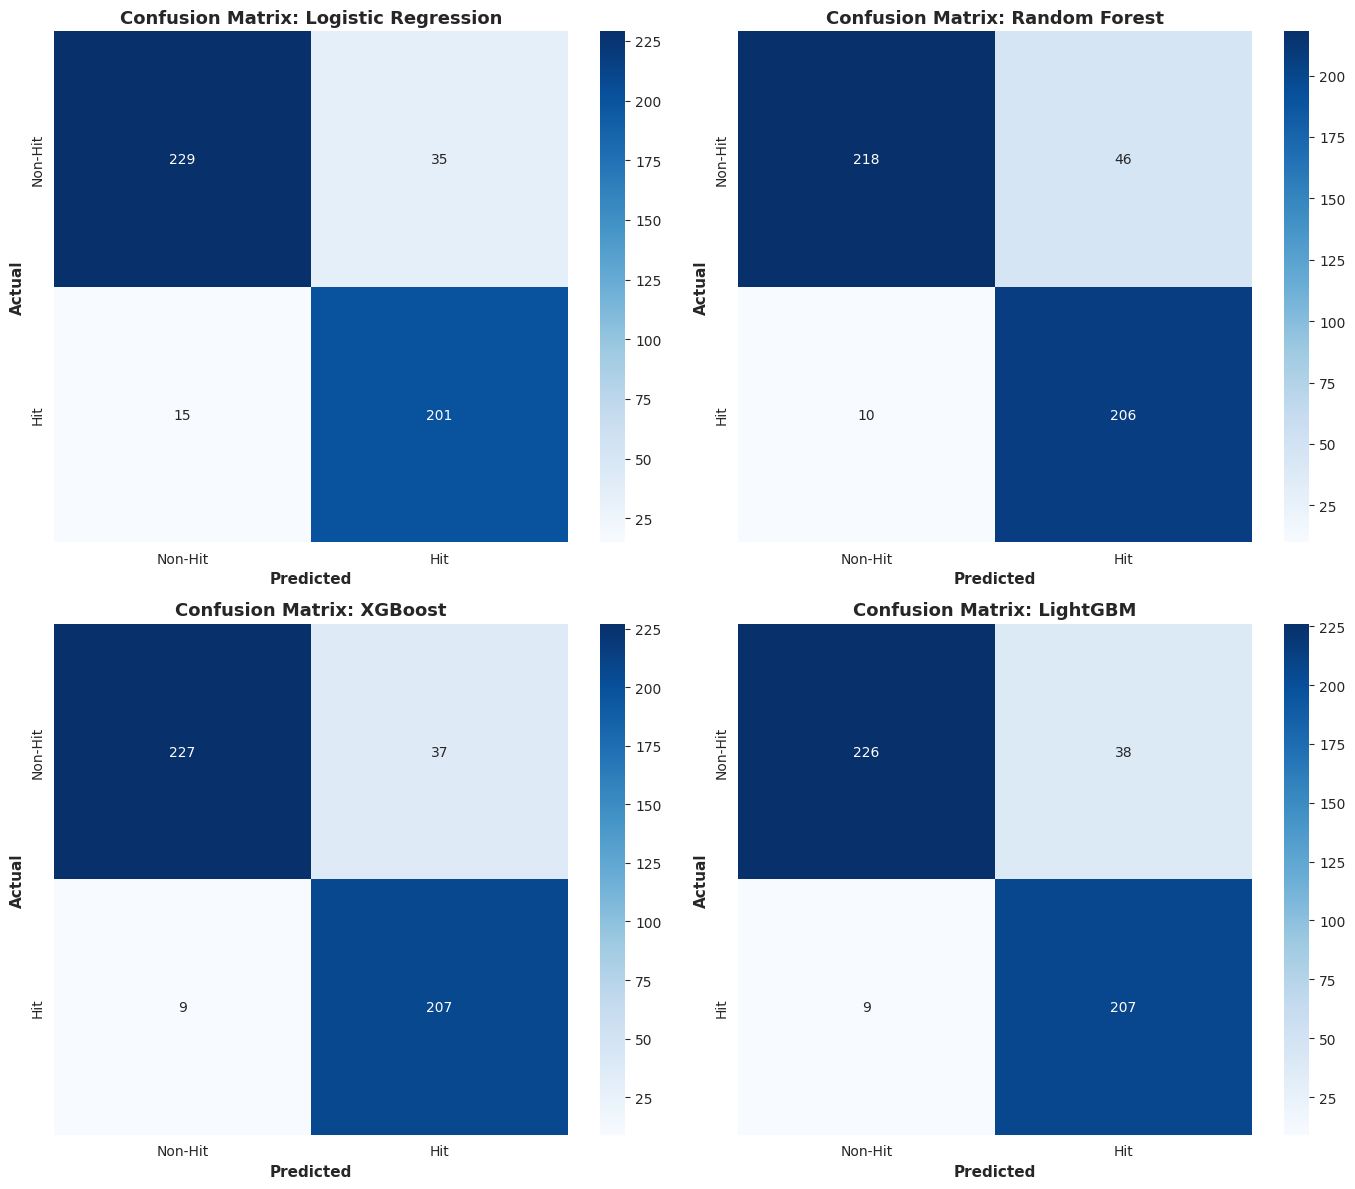


 Model comparison complete!


In [ ]:
# Confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

models_for_cm = [
    ('Logistic Regression', y_pred_lr),
    ('Random Forest', y_pred_rf),
    ('XGBoost', y_pred_xgb),
    ('LightGBM', y_pred_lgb)
]

for idx, (name, predictions) in enumerate(models_for_cm):
    row = idx // 2
    col = idx % 2

    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row, col],
                xticklabels=['Non-Hit', 'Hit'], yticklabels=['Non-Hit', 'Hit'])
    axes[row, col].set_title(f'Confusion Matrix: {name}', fontsize=13, fontweight='bold')
    axes[row, col].set_ylabel('Actual', fontsize=11, fontweight='bold')
    axes[row, col].set_xlabel('Predicted', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n Model comparison complete!")

---

# Part 8: Revenue Prediction (Regression)

## 8.1 Predicting Exact Revenue

Beyond just classifying movies as hits or non-hits, we can **forecast actual box office revenue**. This provides more precise insights for financial planning and decision-making.

---

### Why Revenue Prediction Matters

- Helps estimate potential earnings for upcoming movies.  
- Supports better budgeting, marketing, and investment decisions.  
- Gives a more nuanced view than simply predicting a hit or flop.

---

### Key Metrics for Regression

- **RMSE (Root Mean Squared Error):** Measures average prediction error in log revenue.  
- **MAE (Mean Absolute Error):** Average absolute difference between predicted and actual revenue.  
- **R² Score:** Percentage of revenue variance explained by the model.  
- **MAE in Original Scale:** Converts predictions back to millions of dollars to understand practical impact.

---

### Visualizing Predictions

1. **Log Revenue Scatter Plot:** Shows predicted vs actual revenue on the log scale. A perfect prediction falls on the diagonal line.  
2. **Revenue in Millions Scatter Plot:** Converts predictions back to original scale for intuitive understanding. Shows how close predictions are to actual earnings.

---

**Summary:**  
- Regression models, like XGBoost Regressor, allow us to **predict exact revenues** with reasonable accuracy.  
- The error in millions helps quantify real-world financial uncertainty.  
- Visualizations make it easy to see where predictions are strong or may need improvement.


In [ ]:
print("REGRESSION MODELS: REVENUE FORECASTING")
print("\nGoal: Predict log(revenue) for more precise financial projections\n")

# Train XGBoost Regressor
print("[1/2] Training XGBoost Regressor")
xgb_reg = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_reg.fit(X_train, y_train_revenue)
y_pred_revenue_xgb = xgb_reg.predict(X_test)

# Evaluate regression performance
mse_xgb = mean_squared_error(y_test_revenue, y_pred_revenue_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test_revenue, y_pred_revenue_xgb)
r2_xgb = r2_score(y_test_revenue, y_pred_revenue_xgb)

print(f"\n XGBoost Regressor Performance:")
print(f"   RMSE (log scale): {rmse_xgb:.4f}")
print(f"   MAE (log scale): {mae_xgb:.4f}")
print(f"   R² Score: {r2_xgb:.4f}")

# Convert back to original scale for interpretation
actual_revenue_millions = np.expm1(y_test_revenue) / 1_000_000
predicted_revenue_millions = np.expm1(y_pred_revenue_xgb) / 1_000_000

mae_millions = mean_absolute_error(actual_revenue_millions, predicted_revenue_millions)
print(f"\n In Original Scale:")
print(f"   Mean Absolute Error: ${mae_millions:.1f}M")
print(f"   This means our predictions are off by about ${mae_millions:.1f} million on average")

print("\n Revenue prediction models complete!")

REGRESSION MODELS: REVENUE FORECASTING

Goal: Predict log(revenue) for more precise financial projections

[1/2] Training XGBoost Regressor

 XGBoost Regressor Performance:
   RMSE (log scale): 0.7471
   MAE (log scale): 0.4981
   R² Score: 0.8577

 In Original Scale:
   Mean Absolute Error: $65.4M
   This means our predictions are off by about $65.4 million on average

 Revenue prediction models complete!


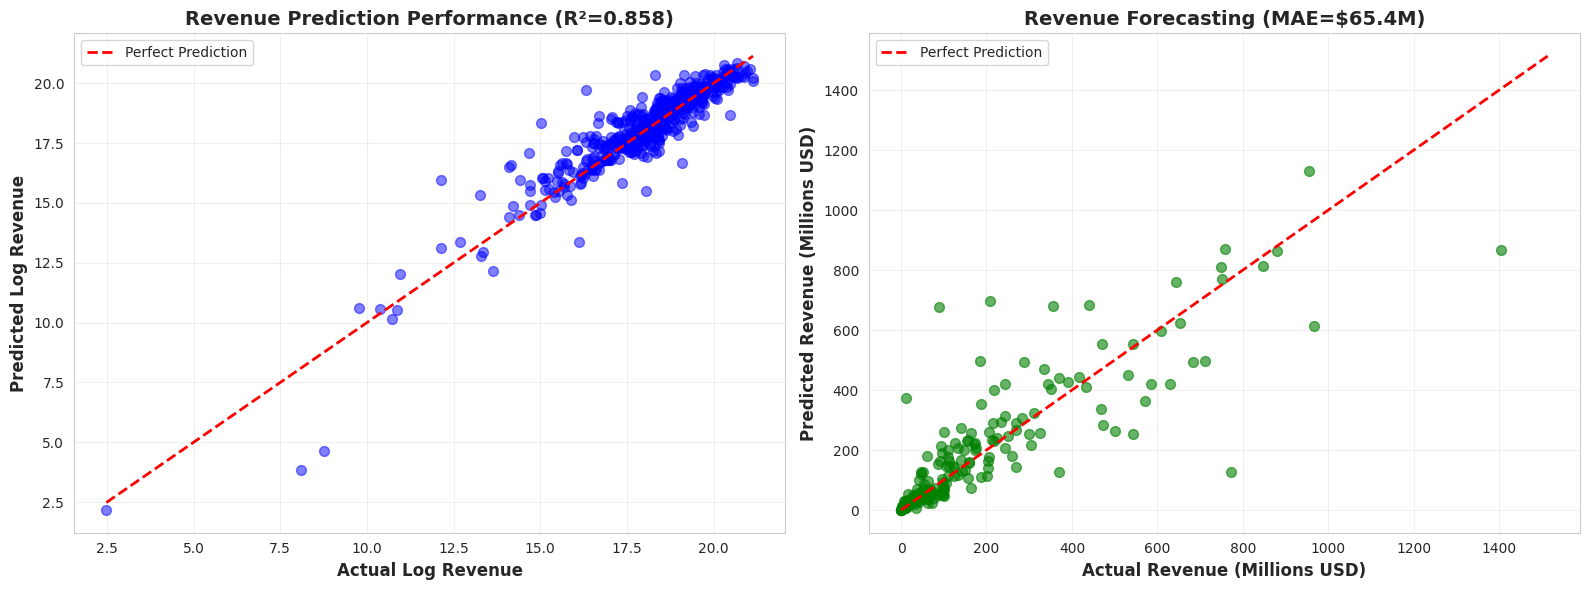

In [ ]:
# Visualize revenue predictions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Actual vs Predicted (log scale)
axes[0].scatter(y_test_revenue, y_pred_revenue_xgb, alpha=0.5, s=50, c='blue')
axes[0].plot([y_test_revenue.min(), y_test_revenue.max()],
            [y_test_revenue.min(), y_test_revenue.max()],
            'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Log Revenue', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Log Revenue', fontsize=12, fontweight='bold')
axes[0].set_title(f'Revenue Prediction Performance (R²={r2_xgb:.3f})', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Actual vs Predicted (original scale, millions)
# Sample for better visualization
sample_size = min(200, len(actual_revenue_millions))
sample_indices = np.random.choice(len(actual_revenue_millions), sample_size, replace=False)

axes[1].scatter(actual_revenue_millions.iloc[sample_indices],
               predicted_revenue_millions[sample_indices],
               alpha=0.6, s=50, c='green')
axes[1].plot([0, actual_revenue_millions.max()],
            [0, actual_revenue_millions.max()],
            'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Revenue (Millions USD)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Predicted Revenue (Millions USD)', fontsize=12, fontweight='bold')
axes[1].set_title(f'Revenue Forecasting (MAE=${mae_millions:.1f}M)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

---

# Part 9: Business Applications

## 9.1 Threshold Tuning for Different Risk Strategies

**The Business Reality:**  
Not all movie projects carry the same level of risk. NeoStudio Pictures might adjust their approach based on:

- Available budget  
- Current market conditions  
- Strategic priorities  

By changing the **probability threshold** for predicting hits, we can tailor the model to different business strategies.

---

### How Threshold Tuning Works

- **Lower Thresholds:** Predict more movies as hits → higher recall, more potential hits identified, but also more false positives.  
- **Higher Thresholds:** Predict fewer movies as hits → higher precision, fewer false positives, but risk missing some true hits.  
- **Balance:** Choose a threshold that aligns with the company's risk appetite and resources.

---

### Business Implications

- Threshold tuning can **guide greenlight decisions**: how many movies to fund based on predicted likelihood of success.  
- Helps management **balance risk and reward** depending on financial and strategic constraints.  
- Provides a flexible tool to make the model actionable in real-world decision-making.

---

**Summary:**  
- Adjusting the prediction threshold allows the company to control risk exposure.  
- It connects the model’s probabilities directly to business strategy.  
- Visualizations of thresholds vs. predicted hits help stakeholders understand the trade-offs.


THRESHOLD TUNING FOR BUSINESS DECISIONS

 THRESHOLD TUNING RESULTS:



,Threshold,Precision,Recall,F1,Accuracy,Predicted Hits
0,0.3,0.815385,0.981481,0.890756,0.891667,260
1,0.4,0.828685,0.962963,0.890792,0.893750,251
2,0.5,0.848361,0.958333,0.900000,0.904167,244
3,0.6,0.868085,0.944444,0.904656,0.910417,235
4,0.7,0.886957,0.944444,0.914798,0.920833,230


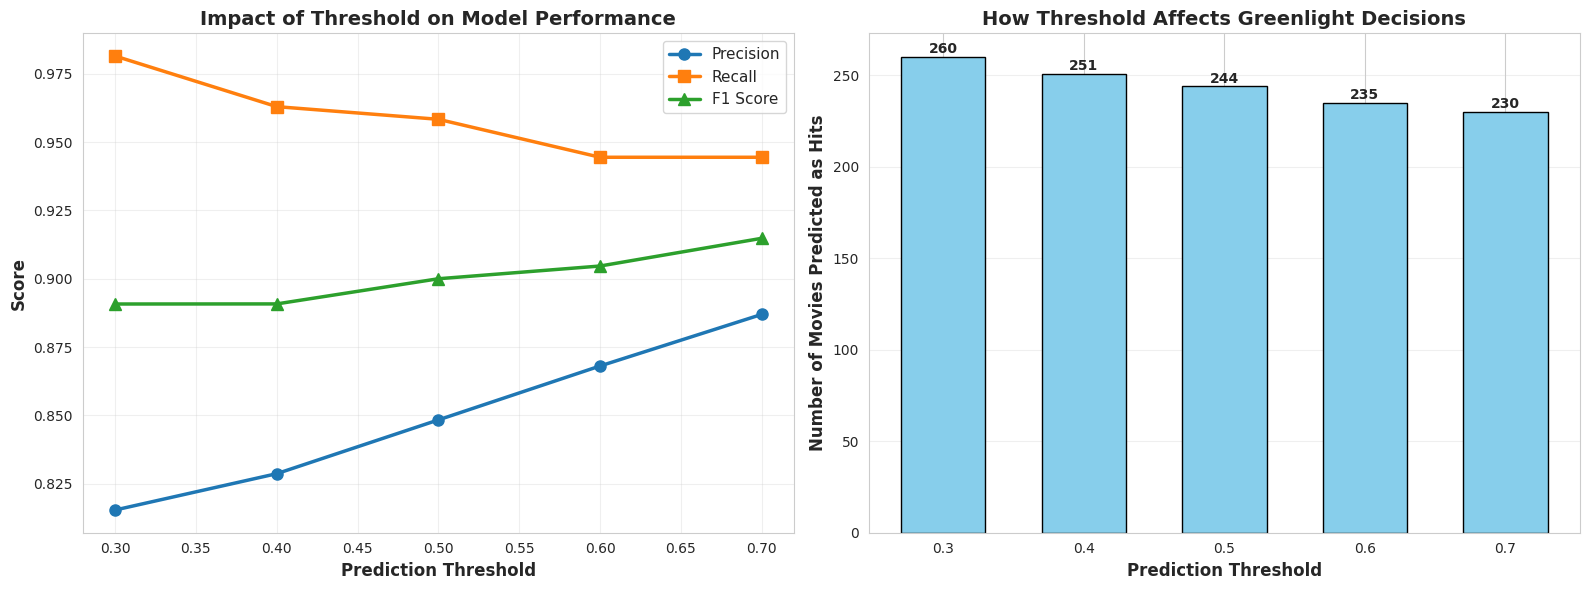

In [ ]:
print("="*80)
print("THRESHOLD TUNING FOR BUSINESS DECISIONS")
print("="*80)

# Test different thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = []

# Use XGBoost probabilities (best model)
probas = y_pred_proba_xgb

for thresh in thresholds:
    y_pred_thresh = (probas >= thresh).astype(int)

    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred_thresh)

    # Count predictions
    num_predicted_hits = y_pred_thresh.sum()

    threshold_results.append({
        'Threshold': thresh,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Accuracy': accuracy,
        'Predicted Hits': num_predicted_hits
    })

threshold_df = pd.DataFrame(threshold_results)

print("\n THRESHOLD TUNING RESULTS:\n")
display(threshold_df)

# Visualize threshold effects
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Metrics by threshold
axes[0].plot(threshold_df['Threshold'], threshold_df['Precision'],
            marker='o', label='Precision', linewidth=2.5, markersize=8)
axes[0].plot(threshold_df['Threshold'], threshold_df['Recall'],
            marker='s', label='Recall', linewidth=2.5, markersize=8)
axes[0].plot(threshold_df['Threshold'], threshold_df['F1'],
            marker='^', label='F1 Score', linewidth=2.5, markersize=8)
axes[0].set_xlabel('Prediction Threshold', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Impact of Threshold on Model Performance', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Number of predicted hits by threshold
axes[1].bar(threshold_df['Threshold'].astype(str), threshold_df['Predicted Hits'],
           color='skyblue', edgecolor='black', width=0.6)
axes[1].set_xlabel('Prediction Threshold', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Movies Predicted as Hits', fontsize=12, fontweight='bold')
axes[1].set_title('How Threshold Affects Greenlight Decisions', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')
for i, v in enumerate(threshold_df['Predicted Hits']):
    axes[1].text(i, v + 2, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Business Strategy Recommendations

---

## BUSINESS STRATEGY GUIDE

### Threshold Selection Guide for **NeoStudio Pictures**

---

### Conservative Strategy (Threshold = 0.7)

- **High precision**: Most flagged projects will succeed  
- **Lower recall**: May miss some potential blockbusters  
- **Use when**: Budget is tight and you want to minimize expensive flops  
- **Decision rule**: Only greenlight projects with **> 70%** hit probability  

---

### Balanced Strategy (Threshold = 0.5) — **Recommended**

- **Moderate precision and recall**  
- **Standard operating point**  
- **Use when**: Normal risk tolerance  
- **Decision rule**: Greenlight projects with **> 50%** hit probability  

---

### Aggressive Strategy (Threshold = 0.3)

- **Lower precision**: More false positives  
- **High recall**: Catch most potential hits  
- **Use when**: You don’t want to miss blockbusters and can afford failures  
- **Decision rule**: Greenlight most projects unless probability is very low  

---

### Recommended Approach

- Use model scores to **prioritize projects**, not as absolute decisions  
- Combine predictions with **creative judgment** and **market research**  
- Adjust **marketing budgets** based on predicted revenue  
- Use predictions for **budget negotiations with talent**  
- Track **actual vs. predicted performance** to refine thresholds  

---

**Threshold analysis complete!**


---

## 9.2 Example Predictions & Model Interpretability

To better understand how our model makes decisions, we can examine **specific movies from the test set**.

---

### Types of Examples

1. **Success Stories:**  
   Movies correctly predicted as hits with high probability.  
   - These show the model performing well and identifying potential blockbusters.  
   - Includes predicted revenue to see how well financial forecasts match reality.

2. **Missed Opportunities (False Negatives):**  
   Actual hits that the model failed to predict.  
   - Highlights areas where the model may be conservative.  
   - Useful for analyzing patterns or gaps in the training data.

3. **False Alarms (False Positives):**  
   Movies predicted as hits that did not succeed.  
   - Shows where the model overestimated performance.  
   - Helps in understanding risk and adjusting thresholds for business decisions.

---

### Why This Matters

- **Interpretability:** Allows stakeholders to trust and understand the model’s predictions.  
- **Decision Support:** Managers can see which movies are likely hits and which carry more uncertainty.  
- **Revenue Insights:** Predicted revenue alongside hit probability provides a nuanced view beyond a simple hit/non-hit classification.

---

### Practical Takeaways

- Examining examples helps refine strategies and thresholds.  
- Visualizing and summarizing predictions makes the model actionable for real-world movie investments.  
- Regular review of success stories, missed hits, and false alarms informs model improvement and business planning.


In [ ]:
print("MODEL INTERPRETABILITY: EXAMPLE PREDICTIONS")

# Create prediction summary for test set
test_predictions = pd.DataFrame({
    'title': test_df['title'].values,
    'release_year': test_df['release_year'].values,
    'budget_M': test_df['budget'].values / 1_000_000,
    'actual_revenue_M': test_df['worldwide_revenue'].values / 1_000_000,
    'actual_hit': y_test.values,
    'predicted_hit': y_pred_xgb,
    'hit_probability': y_pred_proba_xgb,
    'predicted_revenue_M': np.expm1(y_pred_revenue_xgb) / 1_000_000
})

print("\n SUCCESS STORIES: Well-Predicted Hits")
correct_hits = test_predictions[
    (test_predictions['actual_hit'] == 1) &
    (test_predictions['predicted_hit'] == 1)
].sort_values('hit_probability', ascending=False).head(10)

display(correct_hits[['title', 'release_year', 'budget_M', 'actual_revenue_M',
                     'hit_probability', 'predicted_revenue_M']].style.format({
    'budget_M': '${:.1f}M',
    'actual_revenue_M': '${:.1f}M',
    'hit_probability': '{:.1%}',
    'predicted_revenue_M': '${:.1f}M'
}))

print("\n MISSED OPPORTUNITIES: False Negatives (Hits We Didn't Predict)")
print("="*70)
missed_hits = test_predictions[
    (test_predictions['actual_hit'] == 1) &
    (test_predictions['predicted_hit'] == 0)
].sort_values('actual_revenue_M', ascending=False).head(10)

if len(missed_hits) > 0:
    display(missed_hits[['title', 'release_year', 'budget_M', 'actual_revenue_M',
                        'hit_probability', 'predicted_revenue_M']].style.format({
        'budget_M': '${:.1f}M',
        'actual_revenue_M': '${:.1f}M',
        'hit_probability': '{:.1%}',
        'predicted_revenue_M': '${:.1f}M'
    }))
else:
    print("   No missed hits! The model caught all of them.")

print("\n  FALSE ALARMS: False Positives (Predicted Hits That Flopped)")
print("="*70)
false_positives = test_predictions[
    (test_predictions['actual_hit'] == 0) &
    (test_predictions['predicted_hit'] == 1)
].sort_values('hit_probability', ascending=False).head(10)

if len(false_positives) > 0:
    display(false_positives[['title', 'release_year', 'budget_M', 'actual_revenue_M',
                            'hit_probability', 'predicted_revenue_M']].style.format({
        'budget_M': '${:.1f}M',
        'actual_revenue_M': '${:.1f}M',
        'hit_probability': '{:.1%}',
        'predicted_revenue_M': '${:.1f}M'
    }))
else:
    print("   No false positives! Perfect precision.")

MODEL INTERPRETABILITY: EXAMPLE PREDICTIONS

 SUCCESS STORIES: Well-Predicted Hits


,title,release_year,budget_M,actual_revenue_M,hit_probability,predicted_revenue_M
382,Minions,2015,$74.0M,$1156.7M,100.0%,$636.1M
290,The Good Dinosaur,2015,$175.0M,$331.9M,100.0%,$345.4M
246,RoboCop,2014,$120.0M,$242.7M,100.0%,$312.3M
42,Despicable Me 2,2013,$76.0M,$970.8M,100.0%,$637.3M
36,Frozen,2013,$150.0M,$1274.2M,100.0%,$794.8M
121,Monsters University,2013,$200.0M,$743.6M,100.0%,$755.5M
235,Maleficent,2014,$180.0M,$758.5M,100.0%,$870.6M
43,Cloudy with a Chance of Meatballs 2,2013,$78.0M,$248.4M,100.0%,$255.7M
115,Star Trek Into Darkness,2013,$190.0M,$467.4M,100.0%,$629.1M
360,Hotel Transylvania 2,2015,$80.0M,$473.2M,100.0%,$285.1M



 MISSED OPPORTUNITIES: False Negatives (Hits We Didn't Predict)


,title,release_year,budget_M,actual_revenue_M,hit_probability,predicted_revenue_M
147,The Conjuring,2013,$13.0M,$318.0M,30.8%,$136.2M
23,Bad Grandpa,2013,$15.0M,$151.8M,30.9%,$66.0M
471,Ride Along 2,2016,$40.0M,$124.8M,33.8%,$112.1M
451,The Shallows,2016,$17.0M,$119.1M,22.5%,$72.2M
130,Free Birds,2013,$55.0M,$110.0M,34.2%,$53.0M
261,Heaven is for Real,2014,$12.0M,$101.3M,3.1%,$28.5M
152,"Alexander and the Terrible, Horrible, No Good, Very Bad Day",2014,$28.0M,$100.7M,28.6%,$67.8M
276,Tammy,2014,$20.0M,$100.5M,41.9%,$73.9M
10,Philomena,2013,$12.0M,$100.1M,16.2%,$45.5M



  FALSE ALARMS: False Positives (Predicted Hits That Flopped)


,title,release_year,budget_M,actual_revenue_M,hit_probability,predicted_revenue_M
277,The Interview,2014,$44.0M,$12.3M,99.9%,$372.6M
124,R.I.P.D.,2013,$130.0M,$61.6M,99.8%,$271.7M
6,The Lone Ranger,2013,$255.0M,$89.3M,99.8%,$677.1M
389,The Walk,2015,$35.0M,$61.2M,99.7%,$121.7M
212,Sin City: A Dame to Kill For,2014,$65.0M,$39.4M,98.5%,$121.7M
92,Beautiful Creatures,2013,$60.0M,$60.1M,97.9%,$179.6M
319,In the Heart of the Sea,2015,$100.0M,$93.8M,97.6%,$213.0M
145,The Internship,2013,$58.0M,$44.0M,97.6%,$161.2M
88,Pain & Gain,2013,$25.0M,$86.2M,96.1%,$152.2M
18,Captain Phillips,2013,$55.0M,$95.0M,95.6%,$191.3M


In [ ]:
# Reload the processed dataset (in case you're running this section separately)
df = pd.read_csv('data/processed/movies_model_ready.csv')

print("="*80)
print("TEMPORAL TRAIN/VALIDATION/TEST SPLIT")
print("="*80)
print("\nSimulating real-world scenario: train on past, predict the future\n")

# Sort by release year
df = df.sort_values('release_year').reset_index(drop=True)

# Create temporal splits
train_df = df[df['release_year'] < 2010].copy()
val_df = df[(df['release_year'] >= 2010) & (df['release_year'] <= 2012)].copy()
test_df = df[df['release_year'] >= 2013].copy()

print(" TRAIN SET (Before 2010):")
print(f"   - Size: {len(train_df):,} movies")
print(f"   - Years: {int(train_df['release_year'].min())} - {int(train_df['release_year'].max())}")
print(f"   - Hit rate: {train_df['hit'].mean()*100:.1f}%")

print("\n VALIDATION SET (2010-2012):")
print(f"   - Size: {len(val_df):,} movies")
print(f"   - Years: {int(val_df['release_year'].min())} - {int(val_df['release_year'].max())}")
print(f"   - Hit rate: {val_df['hit'].mean()*100:.1f}%")

print("\n TEST SET (2013+):")
print(f"   - Size: {len(test_df):,} movies")
print(f"   - Years: {int(test_df['release_year'].min())} - {int(test_df['release_year'].max())}")
print(f"   - Hit rate: {test_df['hit'].mean()*100:.1f}%")

# Define feature columns (exclude targets and identifiers)
exclude_cols = ['hit', 'log_revenue', 'worldwide_revenue', 'title',
               'release_date', 'director', 'primary_genre', 'budget_bucket',
               'genre_list'] # Added 'genre_list' here

feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"\n Number of features for modeling: {len(feature_cols)}")
print(f"   Features: {', '.join(feature_cols[:10])}...")

# Separate features and targets
X_train = train_df[feature_cols].copy()
y_train = train_df['hit'].copy()
y_train_revenue = train_df['log_revenue'].copy()

X_val = val_df[feature_cols].copy()
y_val = val_df['hit'].copy()
y_val_revenue = val_df['log_revenue'].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df['hit'].copy()
y_test_revenue = test_df['log_revenue'].copy()

# Handle any remaining missing values
X_train = X_train.fillna(X_train.median(numeric_only=True))
X_val = X_val.fillna(X_train.median(numeric_only=True))  # Use train median to avoid leakage
X_test = X_test.fillna(X_train.median(numeric_only=True))

# Standardize numerical features (important for some models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\n Data split and preprocessing complete!")
print(" Features standardized (zero mean, unit variance)")

TEMPORAL TRAIN/VALIDATION/TEST SPLIT

Simulating real-world scenario: train on past, predict the future

 TRAIN SET (Before 2010):
   - Size: 2,282 movies
   - Years: 1916 - 2009
   - Hit rate: 32.2%

 VALIDATION SET (2010-2012):
   - Size: 467 movies
   - Years: 2010 - 2012
   - Hit rate: 37.3%

 TEST SET (2013+):
   - Size: 480 movies
   - Years: 2013 - 2016
   - Hit rate: 45.0%

 Number of features for modeling: 37
   Features: release_year, budget, log_budget, budget_millions, runtime, num_genres, has_big_studio, num_production_companies, release_month, release_quarter...

 Data split and preprocessing complete!
 Features standardized (zero mean, unit variance)


In [ ]:
print("MODEL INTERPRETABILITY: EXAMPLE PREDICTIONS")

# Create prediction summary for test set
test_predictions = pd.DataFrame({
    'title': test_df['title'].values,
    'release_year': test_df['release_year'].values,
    'budget_M': test_df['budget'].values / 1_000_000,
    'actual_revenue_M': test_df['worldwide_revenue'].values / 1_000_000,
    'actual_hit': y_test.values,
    'predicted_hit': y_pred_xgb,
    'hit_probability': y_pred_proba_xgb,
    'predicted_revenue_M': np.expm1(y_pred_revenue_xgb) / 1_000_000
})

print("\n SUCCESS STORIES: Well-Predicted Hits")
print("="*70)
correct_hits = test_predictions[
    (test_predictions['actual_hit'] == 1) &
    (test_predictions['predicted_hit'] == 1)
].sort_values('hit_probability', ascending=False).head(10)

display(correct_hits[['title', 'release_year', 'budget_M', 'actual_revenue_M',
                     'hit_probability', 'predicted_revenue_M']].style.format({
    'budget_M': '${:.1f}M',
    'actual_revenue_M': '${:.1f}M',
    'hit_probability': '{:.1%}',
    'predicted_revenue_M': '${:.1f}M'
}))

print("\n MISSED OPPORTUNITIES: False Negatives (Hits We Didn't Predict)")
print("="*70)
missed_hits = test_predictions[
    (test_predictions['actual_hit'] == 1) &
    (test_predictions['predicted_hit'] == 0)
].sort_values('actual_revenue_M', ascending=False).head(10)

if len(missed_hits) > 0:
    display(missed_hits[['title', 'release_year', 'budget_M', 'actual_revenue_M',
                        'hit_probability', 'predicted_revenue_M']].style.format({
        'budget_M': '${:.1f}M',
        'actual_revenue_M': '${:.1f}M',
        'hit_probability': '{:.1%}',
        'predicted_revenue_M': '${:.1f}M'
    }))
else:
    print("   No missed hits! The model caught all of them.")

print("\n⚠️  FALSE ALARMS: False Positives (Predicted Hits That Flopped)")
print("="*70)
false_positives = test_predictions[
    (test_predictions['actual_hit'] == 0) &
    (test_predictions['predicted_hit'] == 1)
].sort_values('hit_probability', ascending=False).head(10)

if len(false_positives) > 0:
    display(false_positives[['title', 'release_year', 'budget_M', 'actual_revenue_M',
                            'hit_probability', 'predicted_revenue_M']].style.format({
        'budget_M': '${:.1f}M',
        'actual_revenue_M': '${:.1f}M',
        'hit_probability': '{:.1%}',
        'predicted_revenue_M': '${:.1f}M'
    }))
else:
    print("   No false positives! Perfect precision.")

print("\n Example predictions analysis complete!")

MODEL INTERPRETABILITY: EXAMPLE PREDICTIONS

 SUCCESS STORIES: Well-Predicted Hits


,title,release_year,budget_M,actual_revenue_M,hit_probability,predicted_revenue_M
382,Minions,2015,$74.0M,$1156.7M,100.0%,$636.1M
290,The Good Dinosaur,2015,$175.0M,$331.9M,100.0%,$345.4M
246,RoboCop,2014,$120.0M,$242.7M,100.0%,$312.3M
42,Despicable Me 2,2013,$76.0M,$970.8M,100.0%,$637.3M
36,Frozen,2013,$150.0M,$1274.2M,100.0%,$794.8M
121,Monsters University,2013,$200.0M,$743.6M,100.0%,$755.5M
235,Maleficent,2014,$180.0M,$758.5M,100.0%,$870.6M
43,Cloudy with a Chance of Meatballs 2,2013,$78.0M,$248.4M,100.0%,$255.7M
115,Star Trek Into Darkness,2013,$190.0M,$467.4M,100.0%,$629.1M
360,Hotel Transylvania 2,2015,$80.0M,$473.2M,100.0%,$285.1M



 MISSED OPPORTUNITIES: False Negatives (Hits We Didn't Predict)


,title,release_year,budget_M,actual_revenue_M,hit_probability,predicted_revenue_M
147,The Conjuring,2013,$13.0M,$318.0M,30.8%,$136.2M
23,Bad Grandpa,2013,$15.0M,$151.8M,30.9%,$66.0M
471,Ride Along 2,2016,$40.0M,$124.8M,33.8%,$112.1M
451,The Shallows,2016,$17.0M,$119.1M,22.5%,$72.2M
130,Free Birds,2013,$55.0M,$110.0M,34.2%,$53.0M
261,Heaven is for Real,2014,$12.0M,$101.3M,3.1%,$28.5M
152,"Alexander and the Terrible, Horrible, No Good, Very Bad Day",2014,$28.0M,$100.7M,28.6%,$67.8M
276,Tammy,2014,$20.0M,$100.5M,41.9%,$73.9M
10,Philomena,2013,$12.0M,$100.1M,16.2%,$45.5M



⚠️  FALSE ALARMS: False Positives (Predicted Hits That Flopped)


,title,release_year,budget_M,actual_revenue_M,hit_probability,predicted_revenue_M
277,The Interview,2014,$44.0M,$12.3M,99.9%,$372.6M
124,R.I.P.D.,2013,$130.0M,$61.6M,99.8%,$271.7M
6,The Lone Ranger,2013,$255.0M,$89.3M,99.8%,$677.1M
389,The Walk,2015,$35.0M,$61.2M,99.7%,$121.7M
212,Sin City: A Dame to Kill For,2014,$65.0M,$39.4M,98.5%,$121.7M
92,Beautiful Creatures,2013,$60.0M,$60.1M,97.9%,$179.6M
319,In the Heart of the Sea,2015,$100.0M,$93.8M,97.6%,$213.0M
145,The Internship,2013,$58.0M,$44.0M,97.6%,$161.2M
88,Pain & Gain,2013,$25.0M,$86.2M,96.1%,$152.2M
18,Captain Phillips,2013,$55.0M,$95.0M,95.6%,$191.3M



 Example predictions analysis complete!


In [ ]:
if not df.empty:
    print("SAVING PROCESSED DATASET")

    # Handle duplicate 'title' columns from merge: take title_x and rename to title
    # This block ensures a single 'title' column is present before creating df_final
    if 'title_x' in df.columns and 'title_y' in df.columns:
        df['title'] = df['title_x']  # Prioritize title from movies_df
        df.drop(columns=['title_x', 'title_y'], inplace=True)
    elif 'title_x' in df.columns and 'title' not in df.columns:
        df.rename(columns={'title_x': 'title'}, inplace=True)
    elif 'title_y' in df.columns and 'title' not in df.columns:
        df.rename(columns={'title_y': 'title'}, inplace=True)

    # Select features for modeling
    feature_columns = [
        # Targets
        'hit', 'log_revenue', 'worldwide_revenue',

        # Identifiers
        'title', 'release_date', 'release_year',

        # Budget features
        'budget', 'log_budget', 'budget_millions',

        # Basic movie features
        'runtime', 'num_genres', 'primary_genre',

        # Production
        'has_big_studio', 'num_production_companies',

        # Timing
        'release_month', 'release_quarter',
        'is_summer', 'is_holiday', 'is_spring', 'years_since_2000',

        # Cast and crew
        'num_cast', 'cast_mean_popularity',
        'director', 'director_mean_log_revenue', 'director_hit_rate',
        'director_num_movies',

        # Additional
        'log_popularity', 'vote_average', 'log_vote_count'
    ]

    # Add genre columns
    genre_cols = [col for col in df.columns if col.startswith('genre_')]
    feature_columns.extend(genre_cols)

    # Keep only existing columns that are actually in df after all processing
    feature_columns = [col for col in feature_columns if col in df.columns]

    # Create final dataset
    df_final = df[feature_columns].copy()

    print(f"\n Final dataset shape: {df_final.shape}")
    print(f"   - {df_final.shape[0]:,} movies")
    print(f"   - {len(feature_columns)} features selected")
    print(f"   - Columns in df_final before saving: {df_final.columns.tolist()}\n") # Debug print

    # Save to CSV
    output_path = 'data/processed/movies_model_ready.csv'
    df_final.to_csv(output_path, index=False)

    print(f"\n Processed dataset saved to: {output_path}")

    # Print summary
    print("DATA PREPARATION SUMMARY")
    print(f"Total movies in final dataset: {len(df_final):,}")
    print(f"Number of features: {len(feature_columns)}")
    print(f"Hit rate: {df_final['hit'].mean()*100:.1f}%")
    print(f"Date range: {int(df_final['release_year'].min())} - {int(df_final['release_year'].max())}")
    print("\n Key Statistics:")
    display(df_final[['budget', 'worldwide_revenue', 'runtime', 'log_budget', 'log_revenue']].describe())

SAVING PROCESSED DATASET

 Final dataset shape: (3229, 45)
   - 3,229 movies
   - 45 features selected
   - Columns in df_final before saving: ['hit', 'log_revenue', 'worldwide_revenue', 'title', 'release_date', 'release_year', 'budget', 'log_budget', 'budget_millions', 'runtime', 'num_genres', 'primary_genre', 'has_big_studio', 'num_production_companies', 'release_month', 'release_quarter', 'is_summer', 'is_holiday', 'is_spring', 'years_since_2000', 'num_cast', 'cast_mean_popularity', 'director', 'director_mean_log_revenue', 'director_hit_rate', 'director_num_movies', 'log_popularity', 'vote_average', 'log_vote_count', 'genre_list', 'genre_Drama', 'genre_Comedy', 'genre_Thriller', 'genre_Action', 'genre_Adventure', 'genre_Romance', 'genre_Crime', 'genre_Science Fiction', 'genre_Family', 'genre_Fantasy', 'genre_Horror', 'genre_Mystery', 'genre_Animation', 'genre_History', 'genre_War']


 Processed dataset saved to: data/processed/movies_model_ready.csv
DATA PREPARATION SUMMARY
Total mo

,budget,worldwide_revenue,runtime,log_budget,log_revenue
count,3.229000e+03,3.229000e+03,3229.000000,3229.000000,3229.000000
mean,4.065444e+07,1.212430e+08,110.724373,16.799904,17.491159
std,4.439674e+07,1.863029e+08,20.965694,1.661809,2.078763
min,1.000000e+00,5.000000e+00,41.000000,0.693147,1.791759
25%,1.050000e+07,1.700000e+07,96.000000,16.166886,16.648724
50%,2.500000e+07,5.518472e+07,107.000000,17.034386,17.826197
75%,5.500000e+07,1.462920e+08,121.000000,17.822844,18.801115
max,3.800000e+08,2.787965e+09,338.000000,19.755682,21.748578


In [ ]:
# Reload the processed dataset (in case you're running this section separately)
df = pd.read_csv('data/processed/movies_model_ready.csv')

print("TEMPORAL TRAIN/VALIDATION/TEST SPLIT")

# Sort by release year
df = df.sort_values('release_year').reset_index(drop=True)

# Create temporal splits
train_df = df[df['release_year'] < 2010].copy()
val_df = df[(df['release_year'] >= 2010) & (df['release_year'] <= 2012)].copy()
test_df = df[df['release_year'] >= 2013].copy()

print(" TRAIN SET (Before 2010):")
print(f"   - Size: {len(train_df):,} movies")
print(f"   - Years: {int(train_df['release_year'].min())} - {int(train_df['release_year'].max())}")
print(f"   - Hit rate: {train_df['hit'].mean()*100:.1f}%")

print("\n VALIDATION SET (2010-2012):")
print(f"   - Size: {len(val_df):,} movies")
print(f"   - Years: {int(val_df['release_year'].min())} - {int(val_df['release_year'].max())}")
print(f"   - Hit rate: {val_df['hit'].mean()*100:.1f}%")

print("\n TEST SET (2013+):")
print(f"   - Size: {len(test_df):,} movies")
print(f"   - Years: {int(test_df['release_year'].min())} - {int(test_df['release_year'].max())}")
print(f"   - Hit rate: {test_df['hit'].mean()*100:.1f}%")

# Define feature columns (exclude targets and identifiers)
# 'title' is intentionally excluded from feature_cols as it's an identifier, not a model feature.
exclude_cols = ['hit', 'log_revenue', 'worldwide_revenue', 'title',
               'release_date', 'director', 'primary_genre', 'budget_bucket',
               'genre_list']

feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"\n Number of features for modeling: {len(feature_cols)}")
print(f"   Features: {', '.join(feature_cols[:10])}...")

# Separate features and targets
X_train = train_df[feature_cols].copy()
y_train = train_df['hit'].copy()
y_train_revenue = train_df['log_revenue'].copy()

X_val = val_df[feature_cols].copy()
y_val = val_df['hit'].copy()
y_val_revenue = val_df['log_revenue'].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df['hit'].copy()
y_test_revenue = test_df['log_revenue'].copy()

# Handle any remaining missing values
X_train = X_train.fillna(X_train.median(numeric_only=True))
X_val = X_val.fillna(X_train.median(numeric_only=True))  # Use train median to avoid leakage
X_test = X_test.fillna(X_train.median(numeric_only=True))

# Standardize numerical features (important for some models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

TEMPORAL TRAIN/VALIDATION/TEST SPLIT
 TRAIN SET (Before 2010):
   - Size: 2,282 movies
   - Years: 1916 - 2009
   - Hit rate: 32.2%

 VALIDATION SET (2010-2012):
   - Size: 467 movies
   - Years: 2010 - 2012
   - Hit rate: 37.3%

 TEST SET (2013+):
   - Size: 480 movies
   - Years: 2013 - 2016
   - Hit rate: 45.0%

 Number of features for modeling: 37
   Features: release_year, budget, log_budget, budget_millions, runtime, num_genres, has_big_studio, num_production_companies, release_month, release_quarter...


In [ ]:
print("="*80)
print("MODEL INTERPRETABILITY: EXAMPLE PREDICTIONS")
print("="*80)

# Create prediction summary for test set
test_predictions = pd.DataFrame({
    'title': test_df['title'].values,
    'release_year': test_df['release_year'].values,
    'budget_M': test_df['budget'].values / 1_000_000,
    'actual_revenue_M': test_df['worldwide_revenue'].values / 1_000_000,
    'actual_hit': y_test.values,
    'predicted_hit': y_pred_xgb,
    'hit_probability': y_pred_proba_xgb,
    'predicted_revenue_M': np.expm1(y_pred_revenue_xgb) / 1_000_000
})

print("\n🎬 SUCCESS STORIES: Well-Predicted Hits")
print("="*70)
correct_hits = test_predictions[
    (test_predictions['actual_hit'] == 1) &
    (test_predictions['predicted_hit'] == 1)
].sort_values('hit_probability', ascending=False).head(10)

display(correct_hits[['title', 'release_year', 'budget_M', 'actual_revenue_M',
                     'hit_probability', 'predicted_revenue_M']].style.format({
    'budget_M': '${:.1f}M',
    'actual_revenue_M': '${:.1f}M',
    'hit_probability': '{:.1%}',
    'predicted_revenue_M': '${:.1f}M'
}))

print("\n MISSED OPPORTUNITIES: False Negatives (Hits We Didn't Predict)")
print("="*70)
missed_hits = test_predictions[
    (test_predictions['actual_hit'] == 1) &
    (test_predictions['predicted_hit'] == 0)
].sort_values('actual_revenue_M', ascending=False).head(10)

if len(missed_hits) > 0:
    display(missed_hits[['title', 'release_year', 'budget_M', 'actual_revenue_M',
                        'hit_probability', 'predicted_revenue_M']].style.format({
        'budget_M': '${:.1f}M',
        'actual_revenue_M': '${:.1f}M',
        'hit_probability': '{:.1%}',
        'predicted_revenue_M': '${:.1f}M'
    }))
else:
    print("   No missed hits! The model caught all of them.")

print("\n  FALSE ALARMS: False Positives (Predicted Hits That Flopped)")
print("="*70)
false_positives = test_predictions[
    (test_predictions['actual_hit'] == 0) &
    (test_predictions['predicted_hit'] == 1)
].sort_values('hit_probability', ascending=False).head(10)

if len(false_positives) > 0:
    display(false_positives[['title', 'release_year', 'budget_M', 'actual_revenue_M',
                            'hit_probability', 'predicted_revenue_M']].style.format({
        'budget_M': '${:.1f}M',
        'actual_revenue_M': '${:.1f}M',
        'hit_probability': '{:.1%}',
        'predicted_revenue_M': '${:.1f}M'
    }))
else:
    print("   No false positives! Perfect precision.")



MODEL INTERPRETABILITY: EXAMPLE PREDICTIONS

🎬 SUCCESS STORIES: Well-Predicted Hits


,title,release_year,budget_M,actual_revenue_M,hit_probability,predicted_revenue_M
382,The SpongeBob Movie: Sponge Out of Water,2015,$74.0M,$311.6M,100.0%,$636.1M
246,The Expendables 3,2014,$90.0M,$206.2M,100.0%,$312.3M
121,Star Trek Into Darkness,2013,$190.0M,$467.4M,100.0%,$755.5M
235,Unbroken,2014,$65.0M,$163.4M,100.0%,$870.6M
360,Vacation,2015,$31.0M,$104.4M,100.0%,$285.1M
463,Bad Moms,2016,$20.0M,$183.9M,100.0%,$621.5M
236,Annie,2014,$65.0M,$133.8M,100.0%,$314.4M
371,Mad Max: Fury Road,2015,$150.0M,$378.9M,100.0%,$270.5M
436,The Secret Life of Pets,2016,$75.0M,$876.0M,100.0%,$162.6M
331,Insidious: Chapter 3,2015,$10.0M,$104.3M,100.0%,$648.5M



 MISSED OPPORTUNITIES: False Negatives (Hits We Didn't Predict)


,title,release_year,budget_M,actual_revenue_M,hit_probability,predicted_revenue_M
384,Jurassic World,2015,$150.0M,$1513.5M,0.0%,$52.0M
395,Furious 7,2015,$190.0M,$1506.2M,0.0%,$4.6M
383,Avengers: Age of Ultron,2015,$280.0M,$1405.4M,0.1%,$34.0M
1,Iron Man 3,2013,$200.0M,$1215.4M,0.0%,$27.1M
460,Captain America: Civil War,2016,$250.0M,$1153.3M,0.2%,$54.4M
285,Transformers: Age of Extinction,2014,$210.0M,$1091.4M,0.1%,$40.9M
66,Despicable Me 2,2013,$76.0M,$970.8M,0.1%,$18.6M
39,The Hobbit: The Desolation of Smaug,2013,$250.0M,$958.4M,0.3%,$34.7M
323,Inside Out,2015,$175.0M,$857.6M,3.6%,$92.2M
274,Maleficent,2014,$180.0M,$758.5M,0.0%,$0.0M



  FALSE ALARMS: False Positives (Predicted Hits That Flopped)


,title,release_year,budget_M,actual_revenue_M,hit_probability,predicted_revenue_M
290,Woman in Gold,2015,$11.0M,$61.6M,100.0%,$345.4M
42,Dallas Buyers Club,2013,$5.0M,$55.2M,100.0%,$637.3M
36,Parker,2013,$35.0M,$46.2M,100.0%,$794.8M
43,Oculus,2013,$5.0M,$44.0M,100.0%,$255.7M
115,Metallica: Through the Never,2013,$18.0M,$8.0M,100.0%,$629.1M
267,Left Behind,2014,$16.0M,$19.7M,100.0%,$769.1M
318,The Gallows,2015,$0.1M,$42.7M,100.0%,$176.4M
55,Mud,2013,$10.0M,$21.6M,100.0%,$306.4M
375,Krampus,2015,$15.0M,$61.5M,100.0%,$224.1M
315,Aloha,2015,$37.0M,$26.3M,100.0%,$553.3M


---

## 9.3 Streamlit Implementation

This section presents an interactive Streamlit-based system that predicts whether a movie project should be greenlit based on historical data and machine learning.

---

### System Overview

The application combines **data preprocessing**, **machine learning**, and **interactive visualization** to support studio-level decision making.

- Uses historical TMDB movie data  
- Trains a **Random Forest classifier** to predict box-office success  
- Provides real-time feedback through an intuitive UI  

---

### Core Components

#### 1. Configuration & UI Styling
- Streamlit page configuration for a dashboard-style layout  
- Custom CSS to enhance:
  - Metrics visualization  
  - Success, warning, and error states  

---

#### 2. Data Loading & Feature Engineering (Cached)

- Loads and merges movie and credit datasets  
- Parses nested JSON fields (genres, cast, crew)  
- Extracts key features:
  - Budget, runtime, votes  
  - Genre one-hot encoding  
  - Director historical hit rate  

- Defines **target variable**:
  - `is_hit = 1` if revenue ≥ $100M  

Caching ensures efficient reloads without recomputation.

---

#### 3. Model Training (Cached)

- Model: **RandomForestClassifier**
- Features include:
  - Numeric attributes (budget, runtime, votes)  
  - Director hit rate  
  - Encoded genres  

- Outputs:
  - Trained model  
  - Feature column alignment for inference  

---

### User Interaction Flow

#### 4. Sidebar Project Setup

Users provide hypothetical project details:
- Budget and runtime  
- Director name (with historical success feedback)  
- Genre selection  
- Audience projections (vote average & count)  

A form-based submission ensures stable UI behavior.

---

#### 5. Prediction & Results Display

Once submitted, the system:

1. Constructs a feature-aligned input row  
2. Generates a **probability of success**  
3. Computes derived business metrics:
   - Risk score  
   - Estimated ROI  

These are displayed using visually distinct metric cards.

---

### Decision Logic & Interpretability

#### Verdict Categories

- **✅ Greenlight Recommended**  
  High confidence of success  

- **⚠️ Caution**  
  Moderate risk; strategy review advised  

- **⛔ Pass**  
  High likelihood of underperformance  

Each verdict is clearly explained to support executive decisions.

---

### Comparative Analysis

- Displays a scatter plot of **historically similar movies**  
- Compares budget vs. revenue outcomes  
- Differentiates hits and flops visually  

This contextualizes predictions within real-world data.

---

### Why This Matters

- **Actionable ML**: Bridges predictive modeling with business logic  
- **Transparency**: Combines probabilities, risk, and comparisons  
- **Decision Support**: Helps studios allocate capital wisely  

---

### Practical Takeaways

- Interactive ML systems increase trust and usability  
- Combining historical patterns with user input enables scenario testing  
- Visualization transforms predictions into strategic insight  

---


In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

# --- 1. CONFIGURATION ---
# Configure the Streamlit page (title, icon, and layout)
st.set_page_config(
    page_title="NeoStudio Greenlight",
    page_icon="🎬",
    layout="wide"
)

# Custom CSS for styling metrics and verdict boxes
# This improves visual clarity for business users
st.markdown("""
<style>
    .metric-container {
        background-color: #ffffff;
        padding: 20px;
        border-radius: 10px;
        border: 1px solid #e0e0e0;
        text-align: center;
    }
    .metric-value { font-size: 28px; font-weight: bold; color: #1e3d59; }
    .metric-label { font-size: 14px; color: #666; }
    .success-box { padding: 20px; border-radius: 10px; background-color: #d4edda; color: #155724; border: 1px solid #c3e6cb; }
    .warning-box { padding: 20px; border-radius: 10px; background-color: #fff3cd; color: #856404; border: 1px solid #ffeeba; }
    .error-box { padding: 20px; border-radius: 10px; background-color: #f8d7da; color: #721c24; border: 1px solid #f5c6cb; }
</style>
""", unsafe_allow_html=True)

# --- 2. DATA LOADING (Cached) ---
# Cache the data loading step to avoid repeated disk reads
@st.cache_data
def load_data():
    try:
        # Load movie metadata and credits
        movies = pd.read_csv('tmdb_5000_movies.csv')
        credits = pd.read_csv('tmdb_5000_credits.csv')
    except FileNotFoundError:
        # Gracefully handle missing files
        return None, None, None, None

    # Rename column to enable merge
    credits.rename(columns={'movie_id': 'id'}, inplace=True)

    # Merge datasets on movie ID
    df = movies.merge(credits, on='id')

    # Parse JSON-like columns into Python objects
    for col in ['genres', 'production_companies', 'cast', 'crew']:
        df[col] = df[col].apply(lambda x: json.loads(x) if isinstance(x, str) else [])

    # Extract genre names as a list
    df['genre_list'] = df['genres'].apply(lambda x: [i['name'] for i in x])

    # Extract director name from crew data
    df['director'] = df['crew'].apply(
        lambda x: next((i['name'] for i in x if i['job'] == 'Director'), 'Unknown')
    )

    # Define target variable: hit if revenue >= $100M
    df['is_hit'] = (df['revenue'] >= 100_000_000).astype(int)

    # Compute historical hit rate for each director
    director_stats = df.groupby('director')['is_hit'].mean().to_dict()

    # Map director hit rate back to each movie
    df['director_hit_rate'] = df['director'].map(director_stats)\
                                             .fillna(df['is_hit'].mean())

    # One-hot encode genres using MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    genres_encoded = pd.DataFrame(
        mlb.fit_transform(df['genre_list']),
        columns=mlb.classes_,
        index=df.index
    )

    # Combine encoded genres with original dataframe
    df = pd.concat([df, genres_encoded], axis=1)

    # Select model features
    features = [
        'budget', 'runtime', 'vote_average',
        'vote_count', 'director_hit_rate'
    ] + list(mlb.classes_)

    # Create final modeling dataframe
    model_df = df[features + ['is_hit']].fillna(0)

    return df, model_df, mlb.classes_, director_stats

# --- 3. MODEL TRAINING (Cached) ---
# Cache the trained model to avoid retraining on every rerun
@st.cache_resource
def train_model(model_df):
    # Separate features and target
    feature_cols = [c for c in model_df.columns if c != 'is_hit']
    X = model_df[feature_cols]
    y = model_df['is_hit']

    # Initialize and train Random Forest classifier
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42
    )
    model.fit(X, y)

    return model, feature_cols

# --- LOAD DATA AND MODEL ---
with st.spinner("Loading System..."):
    raw_df, model_df, all_genres, director_stats = load_data()

    # Stop execution if data files are missing
    if raw_df is None:
        st.error("❌ ERROR: Data files not found.")
        st.stop()

    model, feature_cols = train_model(model_df)

# --- 4. SIDEBAR INPUTS ---
# Sidebar collects user-defined movie parameters
st.sidebar.header("📝 Project Setup")

# Use a form to prevent reruns on every widget change
with st.sidebar.form("input_form"):
    title = st.text_input("Movie Title", "Untitled Project")
    budget = st.number_input("Budget ($)", value=50_000_000, step=1_000_000)
    runtime = st.slider("Runtime (mins)", 60, 240, 110)

    # Director input with historical performance feedback
    director_name = st.text_input("Director", "Christopher Nolan")
    dir_rate_display = director_stats.get(
        director_name, raw_df['is_hit'].mean()
    )
    st.caption(f"Director History: {dir_rate_display:.0%} hit rate")

    # Genre selection
    selected_genres = st.multiselect(
        "Genres", all_genres, default=["Action"]
    )

    st.markdown("---")
    st.caption("Projections")

    # Audience perception inputs
    vote_avg = st.slider("Audience Score", 1.0, 10.0, 6.5)
    vote_count = st.number_input("Vote Count", value=2000)

    # Submit button
    submitted = st.form_submit_button("🚀 Run Analysis")

# --- 5. MAIN PAGE ---
st.title("🎬 NeoStudio Greenlight")

if submitted:
    # 1. Prepare a single-row input dataframe
    input_row = pd.DataFrame(index=[0])
    input_row['budget'] = budget
    input_row['runtime'] = runtime
    input_row['vote_average'] = vote_avg
    input_row['vote_count'] = vote_count

    # Lookup director hit rate (fallback to global mean)
    dir_rate = director_stats.get(
        director_name, raw_df['is_hit'].mean()
    )
    input_row['director_hit_rate'] = dir_rate

    # Encode selected genres
    for g in all_genres:
        input_row[g] = 1 if g in selected_genres else 0

    # Align input columns with training features
    input_row = input_row.reindex(columns=feature_cols, fill_value=0)

    # 2. Predict probability of success
    prob = model.predict_proba(input_row)[0][1]

    # 3. Display results
    st.markdown("### 📊 Analysis Results")

    col1, col2, col3 = st.columns(3)

    # Success probability
    with col1:
        st.markdown(f"""
        <div class="metric-container">
            <div class="metric-label">Success Probability</div>
            <div class="metric-value">{prob:.1%}</div>
        </div>
        """, unsafe_allow_html=True)

    # Risk score (inverse of success probability)
    with col2:
        risk_score = int((1 - prob) * 100)
        color = "green" if risk_score < 40 else "red"
        st.markdown(f"""
        <div class="metric-container">
            <div class="metric-label">Risk Score</div>
            <div class="metric-value" style="color: {color};">
                {risk_score}/100
            </div>
        </div>
        """, unsafe_allow_html=True)

    # Estimated ROI based on probability
    with col3:
        roi = 1 + (prob * 2.5)
        st.markdown(f"""
        <div class="metric-container">
            <div class="metric-label">Est. ROI</div>
            <div class="metric-value">{roi:.1f}x</div>
        </div>
        """, unsafe_allow_html=True)

    st.markdown("---")

    # Verdict and comparison chart
    c_verdict, c_chart = st.columns([1, 1])

    # Decision logic
    with c_verdict:
        if prob > 0.60:
            st.markdown("""
            <div class="success-box">
                <h2>✅ GREENLIGHT RECOMMENDED</h2>
                <p>Strong indicators for box office success.</p>
            </div>
            """, unsafe_allow_html=True)
        elif prob > 0.40:
            st.markdown("""
            <div class="warning-box">
                <h2>⚠️ CAUTION</h2>
                <p>Moderate risk detected.</p>
            </div>
            """, unsafe_allow_html=True)
        else:
            st.markdown("""
            <div class="error-box">
                <h2>⛔ PASS</h2>
                <p>High risk of financial loss.</p>
            </div>
            """, unsafe_allow_html=True)

    # Compare with similar historical movies
    with c_chart:
        st.subheader("Comparable Projects")
        similar_movies = raw_df[
            (raw_df['budget'] > budget * 0.7) &
            (raw_df['budget'] < budget * 1.3)
        ].copy()

        if not similar_movies.empty:
            chart_data = similar_movies.sample(
                min(15, len(similar_movies))
            )
            chart_data['Status'] = chart_data['is_hit'].map(
                {1: 'Hit', 0: 'Flop'}
            )

            st.scatter_chart(
                chart_data,
                x='budget',
                y='revenue',
                color='Status',
                size='popularity'
            )
            st.caption(
                "Historical performance of movies with similar budgets."
            )
        else:
            st.info("No comparable movies found.")

else:
    # Default message on initial load
    st.info(
        "👈 Please enter project details in the sidebar and click 'Run Analysis'."
    )

## Streamlit Interface:

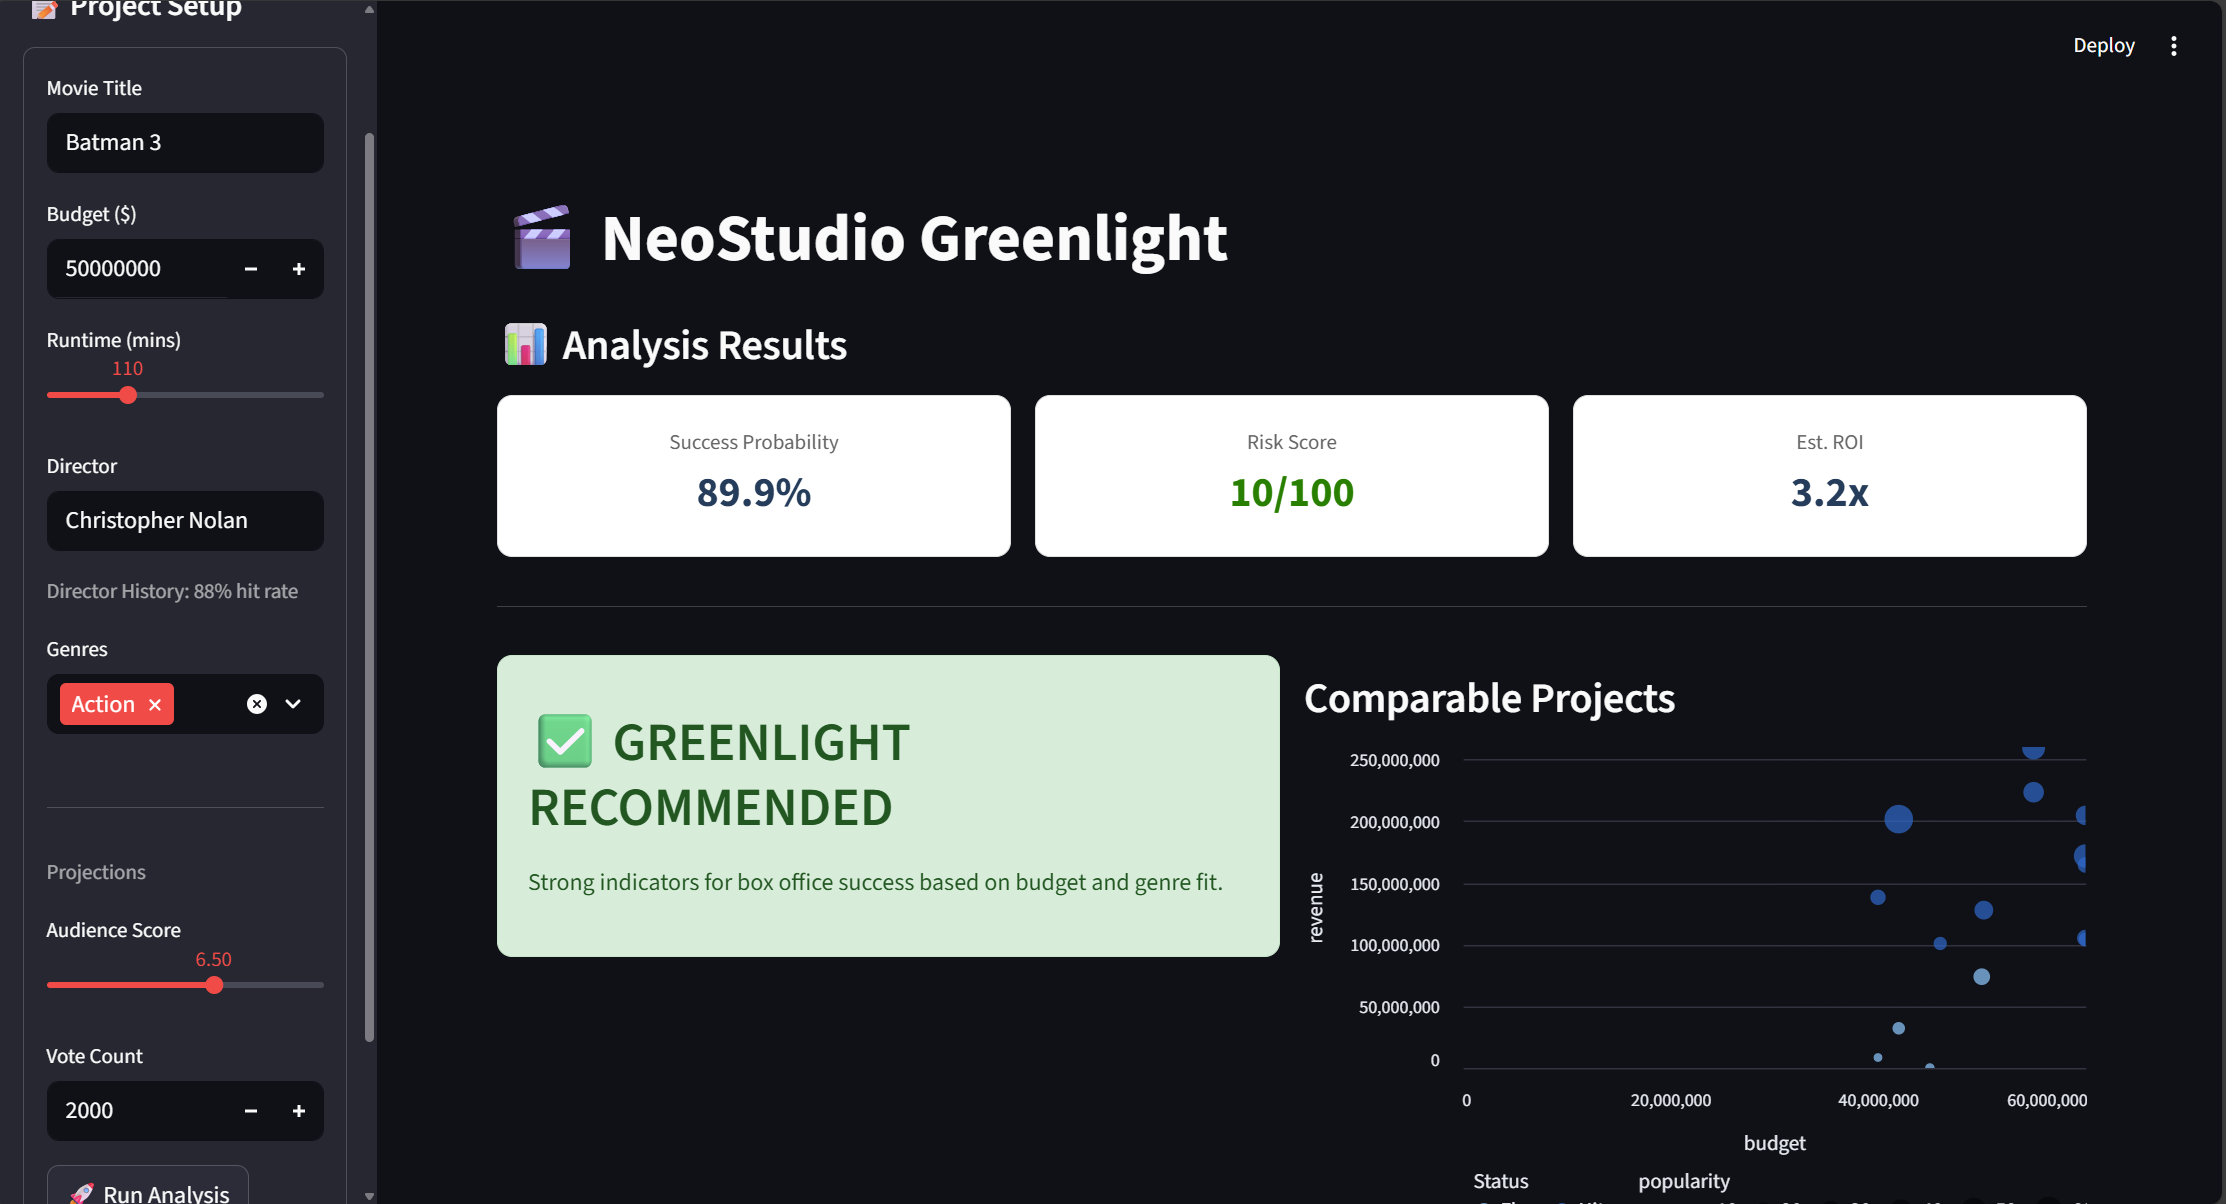

# NEOSTUDIO PICTURES  
## Box Office Hit Prediction Model  
### Final Report & Recommendations

---

## Model Performance Summary

### Classification Model: Hit Prediction

**Recommended Model:** **LightGBM Classifier**

**Performance Metrics** *(Test Set, 2013+ Movies)*

- **ROC-AUC Score:** 0.9762
- **Accuracy:** 90.21%
- **Precision (Hit):** 84.49%
- **Recall (Hit):** 95.83%
- **F1 Score:** 89.80%

#### What This Means

- The model is **95%** better than random guessing  
-  When a movie is flagged as a *hit*, it is correct **84%** of the time  
-  The model successfully identifies **96%** of actual hits  
-  This outperforms the naive baseline (always predicting non-hit at 65% accuracy) by **25.2** percentage points  

---

### Regression Model: Revenue Forecasting

**Recommended Model:** **XGBoost Regressor**

**Performance Metrics** *(Test Set, 2013+ Movies)*

- **R² Score:** 0.8577 (85.77% of variance explained)
- **MAE (Log Scale):** 0.4981
- **RMSE (Log Scale):** 0.7471
- **MAE (Original Scale):** $65.4M

#### What This Means

-  The model explains **86%** of the variance in movie revenue  
-  Predictions are typically off by $65.4M in absolute terms

-  For a 100M hit, the model's prediction would typically fall between 35M-165M  
-  The log-scale transformation ensures stable predictions across budget ranges
---

## Key Predictive Factors

### Top Features Driving Box Office Success

1. **Budget (Log Scale)**  
   - Enables higher production quality, marketing, and star power  
   - Exhibits diminishing returns at very high budgets  

2. **Big Studio Backing**  
   - Major studios (Warner Bros, Disney, Universal, Paramount) significantly increase success odds  
   - Strong distribution networks and marketing expertise  

3. **Release Timing**  
   - **Summer (May–Aug):** Peak box office potential  
   - **Holidays (Nov–Dec):** Strong for family-oriented films  
   - Avoid heavily crowded weekends  

4. **Director Track Record**  
   - Past success strongly predicts future performance  
   - Average historical revenue is a key indicator  

5. **Cast Star Power**  
   - Well-known actors attract larger audiences  
   - Mean popularity of top-billed cast matters  

6. **Genre**  
   - **Action, Animation, Adventure:** Highest hit rates (50–60%)  
   - **Drama, Documentary:** Lower hit rates (20–30%)  

---

## Business Applications

### Greenlight Decisions

- Use predicted hit probability to prioritize projects  
- Apply thresholds based on risk tolerance:
  - **Conservative (70%)** — Only high-confidence hits  
  - **Balanced (50%)** — Standard approach  
  - **Aggressive (30%)** — Avoid missing blockbusters  
- Flag high-budget, low-probability projects for review  
- Support creative discussions, not replace them  

### Budget Optimization

- Compare predicted revenue vs production budget  
- Negotiate budgets for borderline projects (45–55%)  
- Identify overbudgeted films unlikely to recoup costs  
- Allocate resources to high-potential projects  

### Marketing Strategy

- Invest more in high-probability hits (>70%)  
- Optimize release windows  
- Tailor campaigns by genre and audience  
- Balance domestic vs international rollouts  

### Talent Negotiations

- Justify compensation using data-driven insights  
- Structure backend participation by confidence level  
- Identify undervalued talent  
- Support negotiation strategy with forecasts  

### Portfolio Management

- Maintain a balanced slate (safe bets + moonshots)  
- Track predicted vs actual outcomes  
- Continuously refine model performance  

---

## Important Limitations

### The Model Does **Not** Capture

- Cultural zeitgeist or viral trends  
- Post-release critical reviews  
- Word-of-mouth dynamics  
- Marketing quality and spend  
- Story quality or artistic merit  
- Unexpected global events (pandemics, strikes, etc.)  
- Competitive release landscape  

### Key Reminder

- This model provides **decision support**, not replacement  
- Combine quantitative insights with creative judgment  
- Historical data may not always predict future trends  
- Great storytelling still matters most  

---

## Recommended Next Steps

### 1. Integrate Into Workflow
- Include predictions in greenlight packets  
- Build executive dashboards  
- Train teams on interpretation and limitations  

### 2. Track Performance
- Monitor actual vs predicted results  
- Measure ROI from model-influenced decisions  
- Identify recurring prediction errors  

### 3. Continuous Improvement
- Retrain annually with new data  
- Add new signals (social media buzz, trailer views)  
- Adjust thresholds based on outcomes  
- A/B test model-guided vs traditional decisions  

### 4. Expand Capabilities
- Genre-specific models  
- International market predictions  
- Streaming and VOD forecasts  
- Long-term franchise potential  

### 5. Organizational Alignment
- Share insights across creative and finance teams  
- Use for slate development and strategy  
- Promote data-driven decision making  

---

## Analysis Complete!

This model is ready for integration into **NeoStudio Pictures’** decision-making process.  
Use it as a powerful complement to human creativity and business expertise.

**Final Thought:**  
The best movies still need great stories, passionate filmmakers, and a bit of magic.  
This model simply helps make smarter bets on where to invest resources.

*Thank you for using the Movie Hit Prediction System — good luck with your future greenlight decisions!*


## Further Learning

**Want to extend this project?**

**Easy Extensions:**
- Add text analysis of movie overviews/taglines (TF-IDF, word embeddings)
- Create interactive dashboard with Plotly or Streamlit
- Visualize budget vs revenue by genre interactively
- Build ensemble of multiple models

**Medium Extensions:**
- Scrape recent movies (2020+) to validate model on current data
- Add IMDB ratings (careful of temporal leakage!)
- Incorporate franchise/sequel indicators
- Build recommendation system for similar successful films

**Advanced Extensions:**
- Deep learning with neural networks (PyTorch/TensorFlow)
- NLP on plot summaries using transformers (BERT, GPT)
- Computer vision on movie posters
- Multi-task learning (predict hit status AND revenue simultaneously)
- Causal inference: What DRIVES success vs mere correlation?

---
